In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
print(os.getcwd())
os.chdir('../../complete_project/../')
print(os.getcwd())
# Then set up the paths
# import sys

# import os
# os.environ['PYTHONPATH'] = os.getcwd()  # Now points to thesis_code directory
# sys.path.append(os.environ['PYTHONPATH'])
sys.path.append("/home/caspar/thesis_code/CellOracle")
sys.path.append("/home/caspar/thesis_code/complete_project/py files")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/AIFiles")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/baseGRNConstructionFiles")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/oracleInferenceFiles")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/oracleSetup")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/AIFiles/batches")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/AIFiles/single")

/home/caspar/thesis_code/complete_project/notebooks
/home/caspar/thesis_code


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import anndata
import sys
import logging
from datetime import datetime
# import wandb
# import pickle
# import optuna
# #import modified_celloracle as mco
# from CellOracle import celloracle as co
# import igraph as ig
# import CellOracleSetup as setup_module
# import GRNClusterAnalysis as analysis_module
# import GRNInference as inference_module
# import GRNInferenceTest as inference_test_module
# from scipy.sparse import issparse
from typing import Dict, List, Tuple, Optional

log_dir = 'logs'
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(log_dir, f"app_{datetime.now().strftime('%Y_%m_%d')}.log")

# Configure the basic logging
logging.basicConfig(
    filename=log_filename,
    filemode='a',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
    
)

AnnData object with n_obs × n_vars = 30000 × 3000
    obs: 'bc_idx', 'colnames', 'obs_names', 'celltype', 'celltype_general'
    var: 'rownames', 'mean', 'std', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'celltype_colors', 'neighbors', 'pca', 'umap', 'umap_neighbors_sparse'
    obsm: 'X_pca', 'X_umap', 'colnames_factor', 'umap_neighbors'
    varm: 'PCs'
    layers: 'chic', 'raw_chich_counts', 'raw_count', 'unspliced_spliced', 'normalized_count', 'imputed_count', 'simulation_input'
    obsp: 'connectivities', 'distances', 'umap_neighbors_sparse'
Finished calculating activation values for 108 genes.
[28067, 24182, 15671, 19463, 11048, 28975, 4580, 1859, 4683, 3452, 22860, 8676, 19934, 26118, 7152, 9925, 19113, 9734, 23819, 14386, 19583, 16827, 9884, 26766, 26925, 17324, 12611, 138, 23016, 2095, 24179, 19846, 2242, 7789, 27125, 12129, 27068, 7773, 25333, 13547, 5817, 11862, 10532, 17546, 7078, 25229, 11862, 95

In [3]:
import os
import pickle
import numpy as np
import igraph as ig
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from FinalEnvSingleInstance import CellOracleGymEnv as Env
from stable_baselines3 import PPO

# ===================================================================
# CELL 1: SETUP AND CONFIGURATION
# ===================================================================
print("--- Step 1: Setting up paths and configuration ---")

# --- !! IMPORTANT: CONFIGURE YOUR PATHS HERE !! ---
# Path to the directory containing your saved models
MODEL_BASE_PATH = "../celloracle_data/models/final_optuna_please"
RUN_FOLDER_NAMES = [
    "final_run_seed_77",
    "final_run_seed_777",
    "final_run_seed_7777"
]
DATA_BASE_PATH = "../celloracle_data/celloracle_object/new_promoter_without_mescs_trimmed_test_own_umap"
TRANSITION_MATRIX_PATH = "../celloracle_data/transition_matrix/transition_matrix_int32.pkl"
N_TEST_EPISODES = 2000 

# --- Construct full paths ---
ADATA_PATH = os.path.join(DATA_BASE_PATH, "adata.pkl")
PERTURB_GENES_PATH = os.path.join(DATA_BASE_PATH, "perturbable_genes.pkl")
print("Configuration complete.")

# ===================================================================
# LOAD COMMON DATA & PERFORM ONE-TIME SETUP
# ===================================================================
print("\n--- Step 2: Loading common data and performing one-time setup ---")

# Load data
with open(ADATA_PATH, 'rb') as f: adata = pickle.load(f)
with open(PERTURB_GENES_PATH, 'rb') as f: perturbable_genes = pickle.load(f)
with open(TRANSITION_MATRIX_PATH, 'rb') as f: transition_matrix = pickle.load(f)

# Instantiate the environment to access its logic
env_logic = Env(
    adata_object=adata, oracle_perturbable_genes=perturbable_genes, 
    transition_matrix_object=transition_matrix, allow_gene_activation=True, max_steps=20
)

# Determine valid target nodes for each cell type
print("  - Identifying valid target regions...")
target_nodes_dict = {}
for celltype in env_logic.celltypes:
    threshold = env_logic.termination_thresholds[celltype]
    avg_vector = env_logic.average_full_expression_vectors[celltype].reshape(1, -1)
    cell_indices = np.where(env_logic.adata.obs['celltype'] == celltype)[0]
    distances = pairwise_distances(env_logic.AI_input[cell_indices], avg_vector, metric='cosine').flatten()
    target_nodes_dict[celltype] = cell_indices[distances <= threshold].tolist()

# Build the igraph object
print("  - Building transition graph for BFS...")
n_nodes, n_actions = transition_matrix.shape
edge_list, action_indices = [], []
for start_node in range(n_nodes):
    for action_idx in range(n_actions):
        end_node = transition_matrix[start_node, action_idx]
        edge_list.append((start_node, end_node))
        action_indices.append(action_idx)
graph = ig.Graph(n_nodes, edge_list, directed=True)
graph.es['action_index'] = action_indices # Store actions on edges
print(f"Graph built.")





# ===================================================================
# CELL 5: GENERATE TEST SET & RUN EVALUATION
# ===================================================================
print("\n--- Step 5: Generating test set and running evaluation ---")

# Generate the standardized set of start/target pairs for evaluation
# NOTE: The method name in your env was create_test_set, using that.
# If it's different, change it here.
test_episodes, start_indices, targets = env_logic.create_test_set(n_episodes=N_TEST_EPISODES)
print(len(start_indices))
print(f"Generated {len(test_episodes)} test episodes.")




--- Step 1: Setting up paths and configuration ---
Configuration complete.

--- Step 2: Loading common data and performing one-time setup ---
IT IS RELOADED!
  - Identifying valid target regions...
  - Building transition graph for BFS...
Graph built.

--- Step 5: Generating test set and running evaluation ---
2000
Generated 2000 test episodes.


In [4]:
def get_shortest_bfs_path(graph, start_node, target_nodes):
    """
    Calculates the single shortest path from a start node to any node in a list of targets.
    This version uses the correct, robust igraph API for path reconstruction.

    Returns:
        (path_length, path_nodes, path_actions, success_flag)
    """
    if start_node in target_nodes:
        return (0, [start_node], [], True)

    try:
        paths = graph.get_shortest_paths(start_node, to=target_nodes, output='vpath')

        shortest_len = float('inf')
        best_path_nodes = []

        for p in paths:
            if p and len(p) > 1:
                current_len = len(p) - 1
                if current_len < shortest_len:
                    shortest_len = current_len
                    best_path_nodes = p

        if best_path_nodes:
            # --- CORRECTED PATH RECONSTRUCTION LOGIC ---
            path_edge_ids = []
            # Iterate through the path pairwise (node i -> node i+1) to find each edge
            for i in range(len(best_path_nodes) - 1):
                source_node = best_path_nodes[i]
                target_node = best_path_nodes[i+1]
                # Use get_eid() to find the ID of the single edge between two nodes
                edge_id = graph.get_eid(source_node, target_node, directed=True, error=True)
                path_edge_ids.append(edge_id)

            # Now that we have the correct edge IDs, get the corresponding actions
            path_actions = graph.es[path_edge_ids]['action_index']

            return (shortest_len, best_path_nodes, path_actions, True)
        else:
            return (float('inf'), [], [], False)

    except Exception as e:
        # This will now catch specific igraph errors, like if an edge doesn't exist
        # print(f"An error occurred during BFS path calculation: {e}")
        return (float('inf'), [], [], False)


print(f"\n--- Pre-computing optimal BFS paths for all {len(test_episodes)} test episodes ---")
bfs_results = []
for start_node, target_celltype in zip(start_indices, targets):
    bfs_path_length, bfs_nodes, bfs_actions, bfs_success = get_shortest_bfs_path(graph, start_node, target_nodes_dict[target_celltype])
    bfs_results.append({
        "start_node": start_node,
        "target_celltype": target_celltype,
        "bfs_success": bfs_success,
        "bfs_path_length": bfs_path_length if bfs_success else -1,
        "bfs_actions": bfs_actions,
        "bfs_path_nodes": bfs_nodes  # <-- ADD THIS LINE
    })

bfs_results_df = pd.DataFrame(bfs_results)
print("BFS pre-computation complete.")


--- Pre-computing optimal BFS paths for all 2000 test episodes ---


/tmp/ipykernel_3070029/2482233856.py:13: RuntimeWarning: Couldn't reach some vertices. Location: src/paths/unweighted.c:526
  paths = graph.get_shortest_paths(start_node, to=target_nodes, output='vpath')


BFS pre-computation complete.


In [ ]:
import pandas as pd
import numpy as np
import os
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from FinalEnvSingleInstance import CellOracleGymEnv as Env
from FinalEnvSingleInstance import ActionMaskingWrapper
from functools import partial

# ===================================================================
# 1. SETUP & REFACTORED CALLBACK (Unchanged)
# ===================================================================

def collect_episode_data_callback(local_vars, global_vars, results_list: list):
    """
    Callback to collect detailed episode data during evaluation.
    Appends results to the provided 'results_list'.
    """
    if local_vars["dones"][0]:
        info = local_vars["infos"][0]
        rl_success = info.get("goal_reached", False)
        rl_actions = info.get("episode_actions", [])
        rl_path_nodes = info.get("episode_path_nodes", [])
        rl_path_length = len(rl_actions) if rl_success else -1

        vec_env = local_vars["env"]
        base_env = vec_env.envs[0].unwrapped

        start_node = base_env.start_node_for_episode
        target_celltype = base_env.target_celltype_for_episode

        results_list.append({
            "start_node": start_node,
            "target_celltype": target_celltype,
            "rl_success": rl_success,
            "rl_path_length": rl_path_length,
            "rl_actions": rl_actions,
            "rl_path_nodes": rl_path_nodes,
        })

# ===================================================================
# 2. MAIN EVALUATION LOOP (Completed with Mean Length Calculation)
# ===================================================================

all_model_results_dfs = []

# --- Placeholder variables: You must define these before running ---
# MODEL_BASE_PATH = "path/to/your/models"
# RUN_FOLDER_NAMES = ["run_folder_1", "run_folder_2"]
# bfs_results_df = pd.DataFrame(...)
# adata = ...
# perturbable_genes = ...
# transition_matrix = ...
# --------------------------------------------------------------------

env_logic_params = {
    "adata_object": adata, "oracle_perturbable_genes": perturbable_genes,
    "transition_matrix_object": transition_matrix, "max_steps": 20,
    "step_penalty": -0.01, "goal_bonus": 1.0, "distance_reward_scale": 1.0,
    "discount_factor": 0.99, "allow_gene_activation": True,
    "number_of_targets_curriculum": 6, "val_frac": 0.05, "test_frac": 0.05,
    "add_noise": False, "seed": 777, "step_increase_per_phase": 4, # Match the value from your thesis
}

for run_folder in RUN_FOLDER_NAMES:
    print("\n" + "="*80)
    print(f"STARTING EVALUATION FOR MODEL: {run_folder}")
    print("="*80)

    model_path = os.path.join(MODEL_BASE_PATH, run_folder, "final_model_gym.zip")
    model = PPO.load(model_path)
    print(f"Successfully loaded model from {run_folder}")

    # --- Step 1A: Run Evaluation on the TEST Set ---
    print("\n--- Evaluating on TEST set ---")
    test_results_list = []
    test_env = Env(**env_logic_params)
    test_env.switch_to_test_mode(test_mode_on=True)
    wrapped_test_env = ActionMaskingWrapper(Monitor(test_env))

    test_callback = partial(collect_episode_data_callback, results_list=test_results_list)

    evaluate_policy(
        model,
        wrapped_test_env,
        n_eval_episodes=2000,
        deterministic=True,
        render=False,
        callback=test_callback
    )
    test_df = pd.DataFrame(test_results_list)

    # --- Step 1B: Run Evaluation on the VALIDATION Set ---
    print("\n--- Evaluating on VALIDATION set ---")
    validation_results_list = []
    eval_env = Env(**env_logic_params)

    # Manually set the environment to its final curriculum phase and max steps
    eval_env.set_to_max_phase()
    eval_env.switch_between_modes(is_eval_mode=True)
    wrapped_eval_env = ActionMaskingWrapper(Monitor(eval_env))

    validation_callback = partial(collect_episode_data_callback, results_list=validation_results_list)

    evaluate_policy(
        model,
        wrapped_eval_env,
        n_eval_episodes=1000,
        deterministic=True,
        render=False,
        callback=validation_callback
    )
    validation_df = pd.DataFrame(validation_results_list)

    # --- Step 2: Calculate and Display Separate Success Rates & Mean Lengths ---
    print("\n" + "*"*80)
    print("FINAL PERFORMANCE METRICS")
    print("*"*80)
    
    # Test Set Metrics
    if not test_df.empty:
        test_success_rate = test_df['rl_success'].mean()
        successful_test_runs = test_df[test_df['rl_success']]
        print(f"\nTEST SET (N={len(test_df)} episodes):")
        print(f"  - Success Rate: {test_success_rate:.2%}")
        
        if not successful_test_runs.empty:
            mean_test_length = successful_test_runs['rl_path_length'].mean()
            print(f"  - Mean Path Length (successful runs): {mean_test_length:.2f} steps")
        else:
            print("  - Mean Path Length: N/A (no successful runs)")
    else:
        print("\nWARNING: No results collected from the TEST evaluation.")

    # Validation Set Metrics
    if not validation_df.empty:
        validation_success_rate = validation_df['rl_success'].mean()
        successful_val_runs = validation_df[validation_df['rl_success']]
        print(f"\nVALIDATION SET (N={len(validation_df)} episodes):")
        print(f"  - Success Rate: {validation_success_rate:.2%}")

        if not successful_val_runs.empty:
            mean_val_length = successful_val_runs['rl_path_length'].mean()
            print(f"  - Mean Path Length (successful runs): {mean_val_length:.2f} steps")
        else:
             print("  - Mean Path Length: N/A (no successful runs)")
    else:
        print("\nWARNING: No results collected from the VALIDATION evaluation.")
    print("*"*80 + "\n")

    # --- Step 3: Combine Results for Merging and Deeper Analysis (as per your script) ---
    rl_test_only = test_df.copy().reset_index(drop=True)
    rl_test_only['eval_set'] = 'test'

    # 2. Ensure BFS data is also indexed 0..1999 (It should be already, but let's be safe)
    bfs_clean = bfs_results_df.copy().reset_index(drop=True)

    # 3. Check alignment (Optional but recommended)
    if len(rl_test_only) != len(bfs_clean):
        print(f"WARNING: Length mismatch! RL Test: {len(rl_test_only)}, BFS: {len(bfs_clean)}")

    # 4. Concatenate Horizontally (Match Row 0 to Row 0, Row 1 to Row 1)
    # This avoids the 'duplicate start/target' merge explosion issue.
    analysis_df = pd.concat([rl_test_only, bfs_clean], axis=1)

    # Note: We are intentionally excluding the Validation set here because
    # we don't have BFS ground truth for it. If you want to keep it,
    # you would need to concat it back on, but it will have NaN for BFS columns.

    # Verify the merge didn't explode rows
    print(f"Merged DF shape: {analysis_df.shape} (Should be 2000 rows)")

    analysis_df['model_seed'] = run_folder.split("_")[-1]
    all_model_results_dfs.append(analysis_df)

print("\n\nAll model evaluations complete.")
if all_model_results_dfs:
    # Define final_results_df here so the variable name matches the plot code
    final_results_df = pd.concat(all_model_results_dfs, ignore_index=True)
    print("\nFinal combined analysis DataFrame created with shape:", final_results_df.shape)
else:
    print("\nNo analysis results were generated.")

In [17]:
 import itertools
from collections import Counter
import pandas as pd
import numpy as np
import os

def calculate_average_step_distance(path_nodes, umap_coords):
    """Calculates the average Euclidean distance between consecutive nodes in a path."""
    if not path_nodes or len(path_nodes) < 2:
        return 0.0
    path_coordinates = umap_coords[path_nodes]
    step_vectors = np.diff(path_coordinates, axis=0)
    step_distances = np.linalg.norm(step_vectors, axis=1)
    return np.mean(step_distances)

def analyze_and_save_report(all_model_results_dfs, adata, perturbable_genes, output_dir, transition_matrix):
    """
    Final definitive analysis script. Includes all final metrics, including Unused Action
    and Action Repetition analysis. This is the complete version.
    """
    if not all_model_results_dfs:
        print("No model results to analyze. Please run the evaluation loop first.")
        return

    # --- 0. Initial Setup ---
    final_results_df = pd.concat(all_model_results_dfs, ignore_index=True)
    report_lines = []
    umap_coords = adata.obsm['X_umap']
    celltype_array = adata.obs['celltype'].to_numpy()
    final_results_df['start_celltype'] = celltype_array[final_results_df['start_node']]
    n_genes = len(perturbable_genes)
    action_names_map = {i: f"{gene}_KO" for i, gene in enumerate(perturbable_genes)}
    action_names_map.update({i + n_genes: f"{gene}_OE" for i, gene in enumerate(perturbable_genes)})

    rl_successful_runs = final_results_df[final_results_df['rl_success'] == True].copy()
    unique_episodes_df = final_results_df.drop_duplicates(subset=['start_node', 'target_celltype'])
    bfs_successful_runs = unique_episodes_df[unique_episodes_df['bfs_success'] == True].copy()
    succeeded_df = final_results_df[(final_results_df['rl_success'] == True) & (final_results_df['bfs_success'] == True)].copy()

    print("Pre-computing out-degrees for all states...")
    num_states, num_actions = transition_matrix.shape
    out_degrees = np.array([len(np.unique(transition_matrix[i, :])) for i in range(num_states)])
    print("...out-degree calculation complete.")

    # ==============================================================================
    # SECTION 1: OVERALL PERFORMANCE SUMMARY
    # ==============================================================================
    per_model_summary = final_results_df.groupby('model_seed').agg(
        success_rate=('rl_success', 'mean'),
        mean_rl_path_length=('rl_path_length', lambda x: x[x != -1].mean())
    )
    mean_success_rate = per_model_summary['success_rate'].mean()
    std_success_rate = per_model_summary['success_rate'].std()
    mean_rl_length_agg = per_model_summary['mean_rl_path_length'].mean()
    std_rl_length_agg = per_model_summary['mean_rl_path_length'].std()
    bfs_success_rate = len(bfs_successful_runs) / len(unique_episodes_df) if len(unique_episodes_df) > 0 else 0
    mean_bfs_length_agg = bfs_successful_runs['bfs_path_length'].mean()

    report_lines.append("="*80 + "\n                    FINAL COMPREHENSIVE REPORT\n" + "="*80)
    report_lines.append("\n--- Performance Summary ---")
    report_lines.append(f"  Test Set Solvability (BFS Success Rate): {bfs_success_rate:.2%}")
    report_lines.append(f"  RL Agent Mean Success Rate:              {mean_success_rate:.2%} (± {std_success_rate:.2%})")
    report_lines.append(f"  RL Agent Mean Path Length:               {mean_rl_length_agg:.2f} (± {std_rl_length_agg:.2f}) steps (on successful runs only)")
    report_lines.append(f"  Optimal (BFS) Mean Path Length:          {mean_bfs_length_agg:.2f} steps (on solvable episodes only)")

    # ==============================================================================
    # SECTION 2: ACTION STRATEGY SUMMARY
    # ==============================================================================
    all_rl_actions = list(itertools.chain.from_iterable(rl_successful_runs['rl_actions']))
    all_bfs_actions = list(itertools.chain.from_iterable(bfs_successful_runs['bfs_actions']))
    rl_ko_count = sum(1 for action in all_rl_actions if action < n_genes)
    bfs_ko_count = sum(1 for action in all_bfs_actions if action < n_genes)

    report_lines.append("\n\n--- Action Strategy Summary (on successful episodes) ---")
    report_lines.append(f"{'Metric':<35} {'RL Agent':<25} {'Optimal (BFS)':<25}")
    report_lines.append("-" * 85)
    report_lines.append(f"{'Knockout (KO) Ratio':<35} {(rl_ko_count/len(all_rl_actions)):<25.2%}" if all_rl_actions else "N/A")
    report_lines.append(f"{'Overexpression (OE) Ratio':<35} {(1-(rl_ko_count/len(all_rl_actions))):<25.2%}" if all_rl_actions else "N/A")

    # ==============================================================================
    # SECTION 3: UNUSED ACTION ANALYSIS (BFS) - *** NEW SECTION ***
    # ==============================================================================
    all_possible_actions = set(range(num_actions))
    used_bfs_actions = set(all_bfs_actions)
    unused_bfs_actions = all_possible_actions - used_bfs_actions
    
    unused_ko = sum(1 for action in unused_bfs_actions if action < n_genes)
    unused_oe = sum(1 for action in unused_bfs_actions if action >= n_genes)
    
    report_lines.append("\n\n--- Unused Action Analysis (Optimal BFS) ---")
    report_lines.append(f"  - Total available actions: {num_actions}")
    report_lines.append(f"  - Actions never used by BFS: {len(unused_bfs_actions)} ({len(unused_bfs_actions)/num_actions:.2%})")
    if len(unused_bfs_actions) > 0:
        report_lines.append(f"    - Unused KO actions: {unused_ko} ({unused_ko/len(unused_bfs_actions):.2%})")
        report_lines.append(f"    - Unused OE actions: {unused_oe} ({unused_oe/len(unused_bfs_actions):.2%})")

    # ==============================================================================
    # SECTION 4: PATH SIMILARITY ANALYSIS (JACCARD INDEX)
    # ==============================================================================
    def calculate_jaccard(row):
        set_rl = set(row['rl_path_nodes']); set_bfs = set(row['bfs_path_nodes'])
        return len(set_rl.intersection(set_bfs)) / len(set_rl.union(set_bfs)) if len(set_rl.union(set_bfs)) > 0 else 0
    succeeded_df['jaccard_similarity'] = succeeded_df.apply(calculate_jaccard, axis=1)
    mean_jaccard, std_jaccard = succeeded_df['jaccard_similarity'].mean(), succeeded_df['jaccard_similarity'].std()
    report_lines.append("\n\n--- Path Similarity Analysis (on episodes where both succeeded) ---")
    report_lines.append(f"  - Metric: Jaccard Similarity (Intersection over Union of path nodes)")
    report_lines.append(f"  - Mean Similarity:    {mean_jaccard:.2%}")
    report_lines.append(f"  - Std Deviation:      {std_jaccard:.2%}")
    
    # ==============================================================================
    # SECTION 5: ACTION REPETITION ANALYSIS - *** NEW SECTION ***
    # ==============================================================================
    def analyze_action_repetition(actions_list):
        if not actions_list: return (0, 0, 0)
        counts = Counter(actions_list)
        repeated_actions = {act: count for act, count in counts.items() if count > 1}
        if not repeated_actions: return (0, 0, 0)
        total_repetitions = sum(count - 1 for count in repeated_actions.values())
        repeated_oe_counts = [count for act, count in repeated_actions.items() if act >= n_genes]
        repeated_ko_counts = [count for act, count in repeated_actions.items() if act < n_genes]
        avg_oe_repeats = np.mean(repeated_oe_counts) if repeated_oe_counts else 0
        avg_ko_repeats = np.mean(repeated_ko_counts) if repeated_ko_counts else 0
        return total_repetitions, avg_oe_repeats, avg_ko_repeats

    succeeded_df[['rl_total_reps', 'rl_avg_oe_reps', 'rl_avg_ko_reps']] = succeeded_df['rl_actions'].apply(lambda x: pd.Series(analyze_action_repetition(x)))
    succeeded_df[['bfs_total_reps', 'bfs_avg_oe_reps', 'bfs_avg_ko_reps']] = succeeded_df['bfs_actions'].apply(lambda x: pd.Series(analyze_action_repetition(x)))
    report_lines.append("\n\n--- Action Repetition Analysis (Within a Single Path) ---")
    report_lines.append("  - Interpretation: Measures if agents revisit the same perturbation during one task.")
    report_lines.append(f"\n{'Metric':<35} {'RL Agent':<25} {'Optimal (BFS)':<25}")
    report_lines.append(f"{'-'*34:<35} {'-'*24:<25} {'-'*24:<25}")
    report_lines.append(f"{'Avg. Total Repetitions per Path':<35} {succeeded_df['rl_total_reps'].mean():<25.2f} {succeeded_df['bfs_total_reps'].mean():<25.2f}")
    report_lines.append(f"{'Avg. Count for a Repeated OE':<35} {succeeded_df[succeeded_df['rl_avg_oe_reps']>0]['rl_avg_oe_reps'].mean():<25.2f} {succeeded_df[succeeded_df['bfs_avg_oe_reps']>0]['bfs_avg_oe_reps'].mean():<25.2f}")
    report_lines.append(f"{'Avg. Count for a Repeated KO':<35} {succeeded_df[succeeded_df['rl_avg_ko_reps']>0]['rl_avg_ko_reps'].mean():<25.2f} {succeeded_df[succeeded_df['bfs_avg_ko_reps']>0]['bfs_avg_ko_reps'].mean():<25.2f}")

    # ==============================================================================
    # SECTION 6: TRAJECTORY AND ACTION IMPACT ANALYSIS (UMAP DISTANCE)
    # ==============================================================================
    report_lines.append("\n\n--- Trajectory & Action Impact Analysis (UMAP Step Distance) ---")
    rl_oe_distances, rl_ko_distances, bfs_oe_distances, bfs_ko_distances = [], [], [], []
    for _, row in succeeded_df.iterrows():
        rl_actions = row['rl_actions']
        if rl_actions:
            rl_full_path = row['rl_path_nodes'] + [transition_matrix[row['rl_path_nodes'][-1], rl_actions[-1]]]
            for i in range(len(rl_actions)):
                dist = np.linalg.norm(umap_coords[rl_full_path[i]] - umap_coords[rl_full_path[i+1]])
                if rl_actions[i] < n_genes: rl_ko_distances.append(dist)
                else: rl_oe_distances.append(dist)
        bfs_full_path = row['bfs_path_nodes']
        if len(bfs_full_path) > 1:
            for i in range(len(bfs_full_path) - 1):
                start_node, end_node = bfs_full_path[i], bfs_full_path[i+1]
                dist = np.linalg.norm(umap_coords[start_node] - umap_coords[end_node])
                action = np.where(transition_matrix[start_node, :] == end_node)[0]
                if action.size > 0:
                    action_id = action[0]
                    if action_id < n_genes: bfs_ko_distances.append(dist)
                    else: bfs_oe_distances.append(dist)
    mean_rl_step_dist = np.mean(rl_oe_distances + rl_ko_distances) if (rl_oe_distances + rl_ko_distances) else 0.0
    mean_bfs_step_dist = np.mean(bfs_oe_distances + bfs_ko_distances) if (bfs_oe_distances + bfs_ko_distances) else 0.0
    mean_rl_oe_dist = np.mean(rl_oe_distances) if rl_oe_distances else 0.0
    mean_rl_ko_dist = np.mean(rl_ko_distances) if rl_ko_distances else 0.0
    mean_bfs_oe_dist = np.mean(bfs_oe_distances) if bfs_oe_distances else 0.0
    mean_bfs_ko_dist = np.mean(bfs_ko_distances) if bfs_ko_distances else 0.0
    report_lines.append(f"  - Overall Mean Step Distance (RL Agent):      {mean_rl_step_dist:.4f}")
    report_lines.append(f"  - Overall Mean Step Distance (Optimal BFS):   {mean_bfs_step_dist:.4f}")
    report_lines.append("\n  - Action-Specific Impact Comparison (UMAP distance):")
    report_lines.append(f"\n{'Action Type':<20} {'RL Agent':<20} {'Optimal (BFS)':<20}")
    report_lines.append(f"{'-'*19:<20} {'-'*19:<20} {'-'*19:<20}")
    report_lines.append(f"{'Overexpression (OE)':<20} {mean_rl_oe_dist:<20.4f} {mean_bfs_oe_dist:<20.4f}")
    report_lines.append(f"{'Knockout (KO)':<20} {mean_rl_ko_dist:<20.4f} {mean_bfs_ko_dist:<20.4f}")
    
    # ==============================================================================
    # SECTION 7: GLOBAL & AGENT-SPECIFIC HUB CONNECTIVITY ANALYSIS
    # ==============================================================================
    global_oe_hubs, global_ko_hubs = [], []
    for start_node in range(num_states):
        for action_id in range(num_actions):
            end_node = transition_matrix[start_node, action_id]
            hub_score = out_degrees[end_node]
            if action_id < n_genes: global_ko_hubs.append(hub_score)
            else: global_oe_hubs.append(hub_score)
    mean_global_oe_hub = np.mean(global_oe_hubs) if global_oe_hubs else 0.0
    mean_global_ko_hub = np.mean(global_ko_hubs) if global_ko_hubs else 0.0
    rl_oe_hubs, rl_ko_hubs, bfs_oe_hubs, bfs_ko_hubs = [], [], [], []
    for _, row in succeeded_df.iterrows():
        rl_actions = row['rl_actions']
        if rl_actions:
            rl_full_path = row['rl_path_nodes'] + [transition_matrix[row['rl_path_nodes'][-1], rl_actions[-1]]]
            for i in range(len(rl_actions)):
                end_node = rl_full_path[i+1]
                hub_score = out_degrees[end_node]
                if rl_actions[i] < n_genes: rl_ko_hubs.append(hub_score)
                else: rl_oe_hubs.append(hub_score)
        bfs_full_path = row['bfs_path_nodes']
        if len(bfs_full_path) > 1:
            for i in range(len(bfs_full_path) - 1):
                start_node, end_node = bfs_full_path[i], bfs_full_path[i+1]
                action = np.where(transition_matrix[start_node, :] == end_node)[0]
                if action.size > 0:
                    hub_score = out_degrees[end_node]
                    (bfs_oe_hubs if action[0] >= n_genes else bfs_ko_hubs).append(hub_score)
    mean_rl_oe_hub = np.mean(rl_oe_hubs) if rl_oe_hubs else 0.0
    mean_rl_ko_hub = np.mean(rl_ko_hubs) if rl_ko_hubs else 0.0
    mean_bfs_oe_hub = np.mean(bfs_oe_hubs) if bfs_oe_hubs else 0.0
    mean_bfs_ko_hub = np.mean(bfs_ko_hubs) if bfs_ko_hubs else 0.0
    report_lines.append("\n\n--- Hub Connectivity Analysis ---")
    report_lines.append("  - Interpretation: Compares the inherent strategic value (Global) versus the value of")
    report_lines.append("    actions chosen by each agent (Agent-Specific).")
    report_lines.append(f"\n{'Analysis Type':<25} {'Mean Out-Degree (OE)':<25} {'Mean Out-Degree (KO)':<25}")
    report_lines.append(f"{'-'*24:<25} {'-'*24:<25} {'-'*24:<25}")
    report_lines.append(f"{'Global (All Actions)':<25} {mean_global_oe_hub:<25.2f} {mean_global_ko_hub:<25.2f}")
    report_lines.append(f"{'RL Agent Chosen Paths':<25} {mean_rl_oe_hub:<25.2f} {mean_rl_ko_hub:<25.2f}")
    report_lines.append(f"{'Optimal BFS Paths':<25} {mean_bfs_oe_hub:<25.2f} {mean_bfs_ko_hub:<25.2f}")
    
    # ==============================================================================
    # SECTION 8: IN-DEPTH RL AGENT FAILURE ANALYSIS
    # ==============================================================================
    report_lines.append("\n\n--- In-depth RL Agent Failure Analysis ---")
    failed_runs_df = final_results_df[final_results_df['rl_success'] == False].copy()
    total_runs_by_start_type = final_results_df['start_celltype'].value_counts().reset_index()
    total_runs_by_start_type.columns = ['Start Cell Type', 'Total Runs']
    failure_counts_by_start = failed_runs_df['start_celltype'].value_counts().reset_index()
    failure_counts_by_start.columns = ['Start Cell Type', 'Failed Runs']
    start_failure_analysis_df = pd.merge(total_runs_by_start_type, failure_counts_by_start, on='Start Cell Type', how='left').fillna(0)
    start_failure_analysis_df['Failure Rate'] = start_failure_analysis_df['Failed Runs'] / start_failure_analysis_df['Total Runs']
    top_10_start_failures = start_failure_analysis_df.sort_values(by='Failure Rate', ascending=False).head(10)
    report_lines.append("\n  - Top 10 Most Failure-Prone STARTING Cell Types (by Rate):")
    report_lines.append(f"  {'Start Cell Type':<25} {'Failure Rate':<15} {'Failed / Total Runs'}")
    report_lines.append(f"  {'-'*25} {'-'*15} {'-'*20}")
    for _, row in top_10_start_failures.iterrows():
        report_lines.append(f"  {row['Start Cell Type']:<25} {row['Failure Rate']:<15.2%} ({int(row['Failed Runs'])} / {int(row['Total Runs'])})")
    failure_counts_by_target = failed_runs_df['target_celltype'].value_counts().reset_index()
    failure_counts_by_target.columns = ['Target Cell Type', 'Failure Count']
    top_10_target_failures = failure_counts_by_target.head(10)
    report_lines.append("\n\n  - Top 10 Most Frequent Failure TARGETS (by Total Count):")
    report_lines.append(f"  {'Target Cell Type':<25} {'Total Failures'}")
    report_lines.append(f"  {'-'*25} {'-'*15}")
    for _, row in top_10_target_failures.iterrows():
        report_lines.append(f"  {row['Target Cell Type']:<25} {int(row['Failure Count'])}")

    # ==============================================================================
    # SECTION 9: FIRST-STEP INSTINCT ANALYSIS
    # ==============================================================================
    rl_successful_runs['rl_first_action'] = rl_successful_runs['rl_actions'].apply(lambda x: x[0] if x else None)
    bfs_successful_runs['bfs_first_action'] = bfs_successful_runs['bfs_actions'].apply(lambda x: x[0] if x else None)
    report_lines.append("\n\n--- First-Step Instinct Analysis ---")
    report_lines.append(f"\n{'Start Cell Type':<30} {'RL Agent Instinct':<35} {'Optimal (BFS) Instinct':<35}")
    report_lines.append(f"{'-'*30} {'-'*35} {'-'*35}")
    for cell_type in sorted(final_results_df['start_celltype'].unique()):
        rl_group = rl_successful_runs[rl_successful_runs['start_celltype'] == cell_type]
        bfs_group = bfs_successful_runs[bfs_successful_runs['start_celltype'] == cell_type]
        rl_instinct_str = bfs_instinct_str = "N/A"
        if not rl_group.empty and rl_group['rl_first_action'].notna().any():
            rl_instinct_str = action_names_map[rl_group['rl_first_action'].mode()[0]]
        if not bfs_group.empty and bfs_group['bfs_first_action'].notna().any():
            bfs_instinct_str = action_names_map[bfs_group['bfs_first_action'].mode()[0]]
        report_lines.append(f"{cell_type:<30} {rl_instinct_str:<35} {bfs_instinct_str:<35}")

    # ==============================================================================
    # SECTION 10: TOP 10 MOST FREQUENT ACTIONS
    # ==============================================================================
    num_seeds = succeeded_df['model_seed'].nunique()
    bfs_action_counts = Counter(all_bfs_actions)
    rl_action_counts = Counter(all_rl_actions)
    report_lines.append("\n\n--- Top 10 Most Frequent Actions ---")
    report_lines.append(f"\n{'RL Agent Strategy (Avg Count per Seed)':<45} {'Optimal (BFS) Strategy (Total Count)':<45}")
    report_lines.append(f"{'-'*40:<45} {'-'*40:<45}")
    top_rl, top_bfs = rl_action_counts.most_common(10), bfs_action_counts.most_common(10)
    for i in range(10):
        rl_str = bfs_str = ""
        if i < len(top_rl):
            rl_act, rl_total_count = top_rl[i]
            avg_rl_count = rl_total_count / num_seeds
            rl_str = f"{i+1}. {action_names_map[rl_act]:<25} ({avg_rl_count:.1f} avg times)"
        if i < len(top_bfs):
            bfs_act, bfs_count = top_bfs[i]
            bfs_str = f"{i+1}. {action_names_map[bfs_act]:<25} ({bfs_count} times)"
        report_lines.append(f"{rl_str:<45} {bfs_str:<45}")

    # ==============================================================================
    # SECTION 11: TOP 10 ACTION CONNECTIVITY ANALYSIS
    # ==============================================================================
    report_lines.append("\n\n--- Top 10 Action Connectivity Analysis ---")
    report_lines.append("  - Interpretation: Measures the average connectivity (out-degree) of the states reached")
    report_lines.append("    by the most frequently used actions for each agent.")
    
    action_hub_scores = {}
    for action_id in range(num_actions):
        destination_nodes = transition_matrix[:, action_id]
        destination_out_degrees = out_degrees[destination_nodes]
        action_hub_scores[action_id] = np.mean(destination_out_degrees)
        
    report_lines.append(f"\n{'RL Agent Top 10':<35} {'|':<3} {'BFS Top 10':<35}")
    report_lines.append(f"{'Action (Hub Score)':<35} {'|':<3} {'Action (Hub Score)':<35}")
    report_lines.append(f"{'-'*35:<35} {'|':<3} {'-'*35:<35}")

    for i in range(10):
        rl_str = bfs_str = ""
        if i < len(top_rl):
            action_id = top_rl[i][0]
            score = action_hub_scores[action_id]
            rl_str = f"{i+1}. {action_names_map[action_id]:<20} ({score:.2f})"
        if i < len(top_bfs):
            action_id = top_bfs[i][0]
            score = action_hub_scores[action_id]
            bfs_str = f"{i+1}. {action_names_map[action_id]:<20} ({score:.2f})"
        report_lines.append(f"{rl_str:<35} {'|':<3} {bfs_str:<35}")

    # ==============================================================================
    # SECTION 12: TOP 75 'ELITE' ACTION ANALYSIS
    # ==============================================================================
    report_lines.append("\n\n--- Top 75 'Elite' Action Analysis ---")
    report_lines.append("  - Interpretation: Analyzes properties of the most frequently used actions.")
    
    action_umap_distances = {action_id: np.mean(np.linalg.norm(umap_coords[transition_matrix[:, action_id]] - umap_coords, axis=1)) for action_id in range(num_actions)}

    def analyze_top_k_actions(action_counts, k=75):
        top_k_actions = [action for action, count in action_counts.most_common(k)]
        top_oe_actions = [act for act in top_k_actions if act >= n_genes]
        top_ko_actions = [act for act in top_k_actions if act < n_genes]
        oe_hub_scores = [action_hub_scores[act] for act in top_oe_actions]
        ko_hub_scores = [action_hub_scores[act] for act in top_ko_actions]
        oe_dist_scores = [action_umap_distances[act] for act in top_oe_actions]
        ko_dist_scores = [action_umap_distances[act] for act in top_ko_actions]
        return {
            "mean_oe_hub": np.mean(oe_hub_scores) if oe_hub_scores else 0.0, "mean_ko_hub": np.mean(ko_hub_scores) if ko_hub_scores else 0.0,
            "mean_oe_dist": np.mean(oe_dist_scores) if oe_dist_scores else 0.0, "mean_ko_dist": np.mean(ko_dist_scores) if ko_dist_scores else 0.0,
            "oe_count": len(top_oe_actions), "ko_count": len(top_ko_actions)
        }

    rl_elite_stats = analyze_top_k_actions(rl_action_counts)
    bfs_elite_stats = analyze_top_k_actions(bfs_action_counts)
    
    report_lines.append("\n  --- Analysis of Mean Hub Score (Connectivity) ---")
    report_lines.append(f"{'Agent':<25} {'Mean Hub Score (OE)':<30} {'Mean Hub Score (KO)':<30}")
    report_lines.append(f"{'-'*24:<25} {'-'*29:<30} {'-'*29:<30}")
    rl_oe_hub_str = f'{rl_elite_stats["mean_oe_hub"]:.2f} ({rl_elite_stats["oe_count"]} actions)'
    rl_ko_hub_str = f'{rl_elite_stats["mean_ko_hub"]:.2f} ({rl_elite_stats["ko_count"]} actions)'
    bfs_oe_hub_str = f'{bfs_elite_stats["mean_oe_hub"]:.2f} ({bfs_elite_stats["oe_count"]} actions)'
    bfs_ko_hub_str = f'{bfs_elite_stats["mean_ko_hub"]:.2f} ({bfs_elite_stats["ko_count"]} actions)'
    report_lines.append(f"{'RL Agent (Top 75)':<25} {rl_oe_hub_str:<30} {rl_ko_hub_str:<30}")
    report_lines.append(f"{'Optimal BFS (Top 75)':<25} {bfs_oe_hub_str:<30} {bfs_ko_hub_str:<30}")

    report_lines.append("\n\n  --- Analysis of Mean UMAP Step Distance ---")
    report_lines.append(f"{'Agent':<25} {'Mean UMAP Distance (OE)':<30} {'Mean UMAP Distance (KO)':<30}")
    report_lines.append(f"{'-'*24:<25} {'-'*29:<30} {'-'*29:<30}")
    rl_oe_dist_str = f'{rl_elite_stats["mean_oe_dist"]:.4f} ({rl_elite_stats["oe_count"]} actions)'
    rl_ko_dist_str = f'{rl_elite_stats["mean_ko_dist"]:.4f} ({rl_elite_stats["ko_count"]} actions)'
    bfs_oe_dist_str = f'{bfs_elite_stats["mean_oe_dist"]:.4f} ({bfs_elite_stats["oe_count"]} actions)'
    bfs_ko_dist_str = f'{bfs_elite_stats["mean_ko_dist"]:.4f} ({bfs_elite_stats["ko_count"]} actions)'
    report_lines.append(f"{'RL Agent (Top 75)':<25} {rl_oe_dist_str:<30} {rl_ko_dist_str:<30}")
    report_lines.append(f"{'Optimal BFS (Top 75)':<25} {bfs_oe_dist_str:<30} {bfs_ko_dist_str:<30}")

    # ==============================================================================
    # SECTION 13: FULL ACTION DISTRIBUTION & FINAL SAVE
    # ==============================================================================
    all_action_names_list = [action_names_map[i] for i in range(2 * n_genes)]
    distribution_df = pd.DataFrame({
        'ActionName': all_action_names_list,
        'RL_Count (Total)': [rl_action_counts.get(i, 0) for i in range(2*n_genes)],
        'BFS_Count (Total)': [bfs_action_counts.get(i, 0) for i in range(2*n_genes)]
    })
    distribution_df['RL_Probability'] = distribution_df['RL_Count (Total)'] / len(all_rl_actions) if all_rl_actions else 0
    distribution_df['BFS_Probability'] = distribution_df['BFS_Count (Total)'] / len(all_bfs_actions) if all_bfs_actions else 0
    distribution_df = distribution_df.sort_values(by='RL_Probability', ascending=False).reset_index(drop=True)
    
    csv_path = os.path.join(output_dir, "action_distribution.csv")
    report_path = os.path.join(output_dir, "final_analysis_report.txt")
    report_lines.append(f"\n\nA full action distribution has been saved to: {os.path.abspath(csv_path)}")
    report_lines.append("\n" + "="*80)
    
    final_report_str = "\n".join(report_lines)
    print(final_report_str)
    
    try:
        distribution_df.to_csv(csv_path, index=False)
        with open(report_path, "w") as f: f.write(final_report_str)
        print(f"\nReport and distribution CSV successfully saved to '{output_dir}'.")
    except Exception as e:
        print(f"\n!!! ERROR SAVING FILES: {e}")

# --- Call the function ---
# Assumes necessary variables are available in the global scope.
output_directory = os.path.join(MODEL_BASE_PATH, "final_analysis_reports")
os.makedirs(output_directory, exist_ok=True)
analyze_and_save_report(all_model_results_dfs, adata, perturbable_genes, output_dir=output_directory, transition_matrix=transition_matrix)

Pre-computing out-degrees for all states...
...out-degree calculation complete.
                    FINAL COMPREHENSIVE REPORT

--- Performance Summary ---
  Test Set Solvability (BFS Success Rate): 100.00%
  RL Agent Mean Success Rate:              77.25% (± 6.43%)
  RL Agent Mean Path Length:               11.47 (± 0.19) steps (on successful runs only)
  Optimal (BFS) Mean Path Length:          6.76 steps (on solvable episodes only)


--- Action Strategy Summary (on successful episodes) ---
Metric                              RL Agent                  Optimal (BFS)            
-------------------------------------------------------------------------------------
Knockout (KO) Ratio                 47.76%                   
Overexpression (OE) Ratio           52.24%                   


--- Unused Action Analysis (Optimal BFS) ---
  - Total available actions: 216
  - Actions never used by BFS: 44 (20.37%)
    - Unused KO actions: 44 (100.00%)
    - Unused OE actions: 0 (0.00%)


--- Pa

In [22]:
import pandas as pd
import numpy as np
from collections import Counter

# ==============================================================================
# INDEPENDENT ANALYSIS: FULL PATH INEFFICIENCY (REPETITION & UNIQUENESS)
# ==============================================================================
print("="*80)
print("      RUNNING STANDALONE ANALYSIS: FULL PATH INEFFICIENCY")
print("="*80)


# --- 1. SETUP AND DATA PREPARATION ---

# Ensure the master results list is available
if 'all_model_results_dfs' not in locals() or not all_model_results_dfs:
    print("CRITICAL ERROR: 'all_model_results_dfs' is not defined.")
    print("Please re-run your main evaluation loop before this script.")
else:
    # Re-create the master DataFrame to be self-contained
    final_results_df = pd.concat(all_model_results_dfs, ignore_index=True)
    
    # We need n_genes to distinguish between OE and KO for the streak analysis
    if 'perturbable_genes' in locals():
        n_genes = len(perturbable_genes)
    else:
        n_genes = 108
        print("Warning: 'perturbable_genes' not found. Assuming n_genes = 108.")

    # Filter for episodes where both agents succeeded
    succeeded_df = final_results_df[
        (final_results_df['rl_success'] == True) &
        (final_results_df['bfs_success'] == True)
    ].copy()

    if succeeded_df.empty:
        print("No successful episodes found for both agents. Cannot perform analysis.")
    else:
        print(f"Analyzing {len(succeeded_df)} episodes where both RL and BFS succeeded.\n")

        # --- 2. DEFINE HELPER FUNCTIONS ---
        
        def calculate_unique_action_path_length(actions_list):
            """Calculates the length of the path using only unique actions."""
            if not isinstance(actions_list, list) or not actions_list:
                return 0
            return len(set(actions_list))
            
        def analyze_consecutive_repetitions(actions_list, n_genes):
            """Calculates total consecutive repetitions and avg. streak lengths."""
            if not isinstance(actions_list, list) or len(actions_list) < 2:
                return 0, 0.0, 0.0
            total_consecutive_reps = 0
            oe_streak_lengths, ko_streak_lengths = [], []
            current_streak = 1
            for i in range(1, len(actions_list)):
                if actions_list[i] == actions_list[i-1]:
                    total_consecutive_reps += 1
                    current_streak += 1
                else:
                    if current_streak > 1:
                        if actions_list[i-1] >= n_genes:
                            oe_streak_lengths.append(current_streak)
                        else:
                            ko_streak_lengths.append(current_streak)
                    current_streak = 1
            if current_streak > 1:
                if actions_list[-1] >= n_genes:
                    oe_streak_lengths.append(current_streak)
                else:
                    ko_streak_lengths.append(current_streak)
            avg_oe_streak = np.mean(oe_streak_lengths) if oe_streak_lengths else 0.0
            avg_ko_streak = np.mean(ko_streak_lengths) if ko_streak_lengths else 0.0
            return total_consecutive_reps, avg_oe_streak, avg_ko_streak

        # --- 3. APPLY BOTH ANALYSES ---
        
        # Unique Action Path Length
        succeeded_df['rl_unique_path_len'] = succeeded_df['rl_actions'].apply(calculate_unique_action_path_length)
        succeeded_df['bfs_unique_path_len'] = succeeded_df['bfs_actions'].apply(calculate_unique_action_path_length)
        
        # Consecutive Repetitions
        succeeded_df[['rl_consecutive_reps', 'rl_avg_oe_streak', 'rl_avg_ko_streak']] = \
            succeeded_df['rl_actions'].apply(lambda x: pd.Series(analyze_consecutive_repetitions(x, n_genes)))
        succeeded_df[['bfs_consecutive_reps', 'bfs_avg_oe_streak', 'bfs_avg_ko_streak']] = \
            succeeded_df['bfs_actions'].apply(lambda x: pd.Series(analyze_consecutive_repetitions(x, n_genes)))

        # --- 4. PRINT THE COMPREHENSIVE REPORT ---
        
        # --- Table 1: Unique Path Length ---
        mean_rl_original_len = succeeded_df['rl_path_length'].mean()
        mean_bfs_original_len = succeeded_df['bfs_path_length'].mean()
        mean_rl_unique_len = succeeded_df['rl_unique_path_len'].mean()
        mean_bfs_unique_len = succeeded_df['bfs_unique_path_len'].mean()
        rl_redundant_steps = mean_rl_original_len - mean_rl_unique_len
        bfs_redundant_steps = mean_bfs_original_len - mean_bfs_unique_len

        print("\n--- Unique Action Path Length Analysis ---")
        print("  - Interpretation: Measures path length by counting only the first occurrence of each action.")
        print(f"\n{'Metric':<35} {'RL Agent':<25} {'Optimal (BFS)':<25}")
        print(f"{'-'*34:<35} {'-'*24:<25} {'-'*24:<25}")
        print(f"{'Original Mean Path Length':<35} {mean_rl_original_len:<25.2f} {mean_bfs_original_len:<25.2f}")
        print(f"{'Unique Action Mean Path Length':<35} {mean_rl_unique_len:<25.2f} {mean_bfs_unique_len:<25.2f}")
        print("-" * 85)
        print(f"{'Avg. Redundant Steps per Path':<35} {rl_redundant_steps:<25.2f} {bfs_redundant_steps:<25.2f}")
        
        # --- Table 2: Consecutive Repetitions ---
        print("\n\n" + "-"*80)
        print("\n--- Consecutive Action Repetition Analysis ---")
        print("  - Interpretation: Measures the number and length of immediate, back-to-back action repetitions (a_t == a_{t-1}).")
        print(f"\n{'Metric':<45} {'RL Agent':<25} {'Optimal (BFS)':<25}")
        print(f"{'-'*44:<45} {'-'*24:<25} {'-'*24:<25}")
        print(f"{'Avg. Total Consecutive Repetitions per Path':<45} {succeeded_df['rl_consecutive_reps'].mean():<25.2f} {succeeded_df['bfs_consecutive_reps'].mean():<25.2f}")
        print(f"{'Avg. OE Streak Length (if repeated)':<45} {succeeded_df[succeeded_df['rl_avg_oe_streak'] > 0]['rl_avg_oe_streak'].mean():<25.2f} {succeeded_df[succeeded_df['bfs_avg_oe_streak'] > 0]['bfs_avg_oe_streak'].mean():<25.2f}")
        print(f"{'Avg. KO Streak Length (if repeated)':<45} {succeeded_df[succeeded_df['rl_avg_ko_streak'] > 0]['rl_avg_ko_streak'].mean():<25.2f} {succeeded_df[succeeded_df['bfs_avg_ko_streak'] > 0]['bfs_avg_ko_streak'].mean():<25.2f}")

        print("\n" + "="*80)

      RUNNING STANDALONE ANALYSIS: CONSECUTIVELY UNIQUE PATH LENGTH
Analyzing 4635 episodes where both RL and BFS succeeded.


--- Consecutively Unique Path Length Analysis ---
  - Interpretation: Measures path length by collapsing consecutive repetitions (e.g., A,A -> A),
    thereby isolating inefficiency from immediate 'stuttering' actions.

Metric                                        RL Agent                  Optimal (BFS)            
--------------------------------------------  ------------------------  ------------------------ 
Original Mean Path Length                     11.48                     6.03                     
Consecutively Unique Mean Path Length         7.24                      5.87                     
-----------------------------------------------------------------------------------------------
Avg. Redundant CONSECUTIVE Steps per Path     4.24                      0.15                     



In [ ]:
import networkx as nx
import pickle

# --- Run this ONCE ---
print("Building graph and running all-pairs shortest path...")
# ... (your graph building code) ...
shortest_paths_lookup = dict(nx.all_pairs_shortest_path_length(G))
print("...calculation complete.")

# Save the result to a file
with open('shortest_paths_lookup.pkl', 'wb') as f:
    pickle.dump(shortest_paths_lookup, f)
print("Saved shortest path lookup to file.")


# --- In all future runs of your notebook ---
print("Loading pre-computed shortest paths from file...")
with open('shortest_paths_lookup.pkl', 'rb') as f:
    shortest_paths_lookup = pickle.load(f)
print("...loading complete.")

In [23]:
import itertools
from collections import Counter
import pandas as pd
import numpy as np
import os

def calculate_average_step_distance(path_nodes, umap_coords):
    """Calculates the average Euclidean distance between consecutive nodes in a path."""
    if not path_nodes or len(path_nodes) < 2:
        return 0.0

    path_coordinates = umap_coords[path_nodes]
    step_vectors = np.diff(path_coordinates, axis=0)
    step_distances = np.linalg.norm(step_vectors, axis=1)
    return np.mean(step_distances)


def analyze_and_save_report(all_model_results_dfs, adata, perturbable_genes, output_dir, transition_matrix):
    """
    Final version of the analysis script.
    - No networkx graph analysis.
    - Includes a more in-depth failure analysis with Top 10 lists for
      start cell type failure rates and target cell type failure counts.
    """
    if not all_model_results_dfs:
        print("No model results to analyze. Please run the evaluation loop first.")
        return

    # --- 0. Initial Setup ---
    final_results_df = pd.concat(all_model_results_dfs, ignore_index=True)
    report_lines = []
    umap_coords = adata.obsm['X_umap']
    celltype_array = adata.obs['celltype'].to_numpy()
    final_results_df['start_celltype'] = celltype_array[final_results_df['start_node']]
    n_genes = len(perturbable_genes)
    action_names_map = {i: f"{gene}_KO" for i, gene in enumerate(perturbable_genes)}
    action_names_map.update({i + n_genes: f"{gene}_OE" for i, gene in enumerate(perturbable_genes)})

    rl_successful_runs = final_results_df[final_results_df['rl_success'] == True].copy()
    unique_episodes_df = final_results_df.drop_duplicates(subset=['start_node', 'target_celltype'])
    bfs_successful_runs = unique_episodes_df[unique_episodes_df['bfs_success'] == True].copy()
    succeeded_df = final_results_df[(final_results_df['rl_success'] == True) & (final_results_df['bfs_success'] == True)].copy()


    # ==============================================================================
    # SECTION 1: OVERALL PERFORMANCE SUMMARY
    # ==============================================================================
    per_model_summary = final_results_df.groupby('model_seed').agg(
        success_rate=('rl_success', 'mean'),
        mean_rl_path_length=('rl_path_length', lambda x: x[x != -1].mean())
    )
    mean_success_rate = per_model_summary['success_rate'].mean()
    std_success_rate = per_model_summary['success_rate'].std()
    mean_rl_length_agg = per_model_summary['mean_rl_path_length'].mean()
    std_rl_length_agg = per_model_summary['mean_rl_path_length'].std()
    bfs_success_rate = len(bfs_successful_runs) / len(unique_episodes_df) if len(unique_episodes_df) > 0 else 0
    mean_bfs_length_agg = bfs_successful_runs['bfs_path_length'].mean()

    report_lines.append("="*80 + "\n                    FINAL COMPREHENSIVE REPORT\n" + "="*80)
    report_lines.append("\n--- Performance Summary ---")
    report_lines.append(f"  Test Set Solvability (BFS Success Rate): {bfs_success_rate:.2%}")
    report_lines.append(f"  RL Agent Mean Success Rate:              {mean_success_rate:.2%} (± {std_success_rate:.2%})")
    report_lines.append(f"  RL Agent Mean Path Length:               {mean_rl_length_agg:.2f} (± {std_rl_length_agg:.2f}) steps (on successful runs only)")
    report_lines.append(f"  Optimal (BFS) Mean Path Length:          {mean_bfs_length_agg:.2f} steps (on solvable episodes only)")

    # ==============================================================================
    # SECTION 2: ACTION STRATEGY SUMMARY
    # ==============================================================================
    all_rl_actions = list(itertools.chain.from_iterable(rl_successful_runs['rl_actions']))
    all_bfs_actions = list(itertools.chain.from_iterable(bfs_successful_runs['bfs_actions']))
    rl_ko_count = sum(1 for action in all_rl_actions if action < n_genes)
    bfs_ko_count = sum(1 for action in all_bfs_actions if action < n_genes)

    report_lines.append("\n\n--- Action Strategy Summary (on successful episodes) ---")
    report_lines.append(f"{'Metric':<35} {'RL Agent':<25} {'Optimal (BFS)':<25}")
    report_lines.append("-" * 85)
    report_lines.append(f"{'Knockout (KO) Ratio':<35} {rl_ko_count/len(all_rl_actions):<25.2%} {bfs_ko_count/len(all_bfs_actions):<25.2%}")
    report_lines.append(f"{'Overexpression (OE) Ratio':<35} {1-(rl_ko_count/len(all_rl_actions)):<25.2%} {1-(bfs_ko_count/len(all_bfs_actions)):<25.2%}")

    # ==============================================================================
    # SECTION 3: PATH SIMILARITY ANALYSIS (JACCARD INDEX)
    # ==============================================================================
    def calculate_jaccard(row):
        set_rl = set(row['rl_path_nodes'])
        set_bfs = set(row['bfs_path_nodes'])
        return len(set_rl.intersection(set_bfs)) / len(set_rl.union(set_bfs)) if len(set_rl.union(set_bfs)) > 0 else 0
    succeeded_df['jaccard_similarity'] = succeeded_df.apply(calculate_jaccard, axis=1)
    mean_jaccard, std_jaccard = succeeded_df['jaccard_similarity'].mean(), succeeded_df['jaccard_similarity'].std()

    report_lines.append("\n\n--- Path Similarity Analysis (on episodes where both succeeded) ---")
    report_lines.append(f"  - Metric: Jaccard Similarity (Intersection over Union of path nodes)")
    report_lines.append(f"  - Mean Similarity:    {mean_jaccard:.2%}")
    report_lines.append(f"  - Std Deviation:      {std_jaccard:.2%}")
    report_lines.append("  - Interpretation: A low score indicates the RL agent finds novel, divergent paths.")

    # ==============================================================================
    # SECTION 4: TRAJECTORY AND ACTION IMPACT ANALYSIS (UMAP DISTANCE)
    # ==============================================================================
    report_lines.append("\n\n--- Trajectory & Action Impact Analysis (UMAP Step Distance) ---")

    rl_oe_distances, rl_ko_distances = [], []
    bfs_oe_distances, bfs_ko_distances = [], []

    for _, row in succeeded_df.iterrows():
        rl_actions = row['rl_actions']
        if rl_actions:
            rl_full_path = row['rl_path_nodes'] + [transition_matrix[row['rl_path_nodes'][-1], rl_actions[-1]]]
            for i in range(len(rl_actions)):
                dist = np.linalg.norm(umap_coords[rl_full_path[i]] - umap_coords[rl_full_path[i+1]])
                if rl_actions[i] < n_genes: rl_ko_distances.append(dist)
                else: rl_oe_distances.append(dist)

        bfs_full_path = row['bfs_path_nodes']
        if len(bfs_full_path) > 1:
            for i in range(len(bfs_full_path) - 1):
                start_node, end_node = bfs_full_path[i], bfs_full_path[i+1]
                dist = np.linalg.norm(umap_coords[start_node] - umap_coords[end_node])
                action = np.where(transition_matrix[start_node, :] == end_node)[0]
                if action.size > 0:
                    action_id = action[0]
                    if action_id < n_genes: bfs_ko_distances.append(dist)
                    else: bfs_oe_distances.append(dist)

    mean_rl_step_dist = np.mean(rl_oe_distances + rl_ko_distances) if (rl_oe_distances + rl_ko_distances) else 0.0
    mean_bfs_step_dist = np.mean(bfs_oe_distances + bfs_ko_distances) if (bfs_oe_distances + bfs_ko_distances) else 0.0
    mean_rl_oe_dist = np.mean(rl_oe_distances) if rl_oe_distances else 0.0
    mean_rl_ko_dist = np.mean(rl_ko_distances) if rl_ko_distances else 0.0
    mean_bfs_oe_dist = np.mean(bfs_oe_distances) if bfs_oe_distances else 0.0
    mean_bfs_ko_dist = np.mean(bfs_ko_distances) if bfs_ko_distances else 0.0

    report_lines.append(f"  - Overall Mean Step Distance (RL Agent):      {mean_rl_step_dist:.4f}")
    report_lines.append(f"  - Overall Mean Step Distance (Optimal BFS):   {mean_bfs_step_dist:.4f}")
    report_lines.append("\n  - Action-Specific Impact Comparison:")
    report_lines.append(f"\n{'Action Type':<20} {'RL Agent':<20} {'Optimal (BFS)':<20}")
    report_lines.append(f"{'-'*19:<20} {'-'*19:<20} {'-'*19:<20}")
    report_lines.append(f"{'Overexpression (OE)':<20} {mean_rl_oe_dist:<20.4f} {mean_bfs_oe_dist:<20.4f}")
    report_lines.append(f"{'Knockout (KO)':<20} {mean_rl_ko_dist:<20.4f} {mean_bfs_ko_dist:<20.4f}")

    # ==============================================================================
    # SECTION 5: IN-DEPTH RL AGENT FAILURE ANALYSIS - *** NEW & IMPROVED SECTION ***
    # ==============================================================================
    report_lines.append("\n\n--- In-depth RL Agent Failure Analysis ---")

    failed_runs_df = final_results_df[final_results_df['rl_success'] == False].copy()

    # --- Analysis 1: Top 10 Highest Failure Rates by STARTING Cell Type ---
    total_runs_by_start_type = final_results_df['start_celltype'].value_counts().reset_index()
    total_runs_by_start_type.columns = ['Start Cell Type', 'Total Runs']

    failure_counts_by_start = failed_runs_df['start_celltype'].value_counts().reset_index()
    failure_counts_by_start.columns = ['Start Cell Type', 'Failed Runs']

    start_failure_analysis_df = pd.merge(total_runs_by_start_type, failure_counts_by_start, on='Start Cell Type', how='left').fillna(0)
    start_failure_analysis_df['Failure Rate'] = start_failure_analysis_df['Failed Runs'] / start_failure_analysis_df['Total Runs']
    top_10_start_failures = start_failure_analysis_df.sort_values(by='Failure Rate', ascending=False).head(10)

    report_lines.append("\n  - Top 10 Most Failure-Prone STARTING Cell Types (by Rate):")
    report_lines.append(f"  {'Start Cell Type':<25} {'Failure Rate':<15} {'Failed / Total Runs'}")
    report_lines.append(f"  {'-'*25} {'-'*15} {'-'*20}")
    for _, row in top_10_start_failures.iterrows():
        report_lines.append(f"  {row['Start Cell Type']:<25} {row['Failure Rate']:<15.2%} ({int(row['Failed Runs'])} / {int(row['Total Runs'])})")

    # --- Analysis 2: Top 10 Most Frequent Failure TARGETS (by Count) ---
    failure_counts_by_target = failed_runs_df['target_celltype'].value_counts().reset_index()
    failure_counts_by_target.columns = ['Target Cell Type', 'Failure Count']
    top_10_target_failures = failure_counts_by_target.head(10)

    report_lines.append("\n\n  - Top 10 Most Frequent Failure TARGETS (by Total Count):")
    report_lines.append(f"  {'Target Cell Type':<25} {'Total Failures'}")
    report_lines.append(f"  {'-'*25} {'-'*15}")
    for _, row in top_10_target_failures.iterrows():
        report_lines.append(f"  {row['Target Cell Type']:<25} {int(row['Failure Count'])}")


    # ==============================================================================
    # SECTION 6: FIRST-STEP INSTINCT ANALYSIS
    # ==============================================================================
    rl_successful_runs['rl_first_action'] = rl_successful_runs['rl_actions'].apply(lambda x: x[0] if x else None)
    bfs_successful_runs['bfs_first_action'] = bfs_successful_runs['bfs_actions'].apply(lambda x: x[0] if x else None)
    report_lines.append("\n\n--- First-Step Instinct Analysis (Most common first action from a start cell type) ---")
    report_lines.append(f"\n{'Start Cell Type':<30} {'RL Agent Instinct':<35} {'Optimal (BFS) Instinct':<35}")
    report_lines.append(f"{'-'*30} {'-'*35} {'-'*35}")
    for cell_type in sorted(final_results_df['start_celltype'].unique()):
        rl_group = rl_successful_runs[rl_successful_runs['start_celltype'] == cell_type]
        bfs_group = bfs_successful_runs[bfs_successful_runs['start_celltype'] == cell_type]
        rl_instinct_str = bfs_instinct_str = "N/A"
        if not rl_group.empty and rl_group['rl_first_action'].notna().any():
            rl_instinct_str = action_names_map[rl_group['rl_first_action'].mode()[0]]
        if not bfs_group.empty and bfs_group['bfs_first_action'].notna().any():
            bfs_instinct_str = action_names_map[bfs_group['bfs_first_action'].mode()[0]]
        report_lines.append(f"{cell_type:<30} {rl_instinct_str:<35} {bfs_instinct_str:<35}")

    # ==============================================================================
    # SECTION 7: TOP 10 MOST FREQUENT ACTIONS
    # ==============================================================================
    num_seeds = succeeded_df['model_seed'].nunique()
    bfs_action_counts = Counter(all_bfs_actions)
    rl_action_counts = Counter(all_rl_actions)
    report_lines.append("\n\n--- Top 10 Most Frequent Actions ---")
    report_lines.append(f"\n{'RL Agent Strategy (Avg Count per Seed)':<45} {'Optimal (BFS) Strategy (Total Count)':<45}")
    report_lines.append(f"{'-'*40:<45} {'-'*40:<45}")
    top_rl, top_bfs = rl_action_counts.most_common(10), bfs_action_counts.most_common(10)
    for i in range(10):
        rl_str = bfs_str = ""
        if i < len(top_rl):
            rl_act, rl_total_count = top_rl[i]
            avg_rl_count = rl_total_count / num_seeds
            rl_str = f"{i+1}. {action_names_map[rl_act]:<25} ({avg_rl_count:.1f} avg times)"
        if i < len(top_bfs):
            bfs_act, bfs_count = top_bfs[i]
            bfs_str = f"{i+1}. {action_names_map[bfs_act]:<25} ({bfs_count} times)"
        report_lines.append(f"{rl_str:<45} {bfs_str:<45}")

    # ==============================================================================
    # SECTION 8: FULL ACTION DISTRIBUTION & FINAL SAVE
    # ==============================================================================
    all_action_names_list = [action_names_map[i] for i in range(2 * n_genes)]
    distribution_df = pd.DataFrame({
        'ActionName': all_action_names_list,
        'RL_Count (Total)': [rl_action_counts.get(i, 0) for i in range(2*n_genes)],
        'BFS_Count (Total)': [bfs_action_counts.get(i, 0) for i in range(2*n_genes)]
    })
    distribution_df['RL_Probability'] = distribution_df['RL_Count (Total)'] / len(all_rl_actions) if all_rl_actions else 0
    distribution_df['BFS_Probability'] = distribution_df['BFS_Count (Total)'] / len(all_bfs_actions) if all_bfs_actions else 0
    distribution_df = distribution_df.sort_values(by='RL_Probability', ascending=False).reset_index(drop=True)

    csv_path = os.path.join(output_dir, "action_distribution.csv")
    report_path = os.path.join(output_dir, "final_analysis_report.txt")

    report_lines.append(f"\n\nA full action distribution has been saved to: {os.path.abspath(csv_path)}")
    report_lines.append("\n" + "="*80)

    final_report_str = "\n".join(report_lines)
    print(final_report_str)

    try:
        distribution_df.to_csv(csv_path, index=False)
        with open(report_path, "w") as f: f.write(final_report_str)
        print(f"\nReport and distribution CSV successfully saved to '{output_dir}'.")
    except Exception as e:
        print(f"\n!!! ERROR SAVING FILES: {e}")

# --- Call the function ---
# Assumes MODEL_BASE_PATH, all_model_results_dfs, adata, perturbable_genes,
# and transition_matrix are available in the global scope.
output_directory = os.path.join(MODEL_BASE_PATH, "final_analysis_reports")
os.makedirs(output_directory, exist_ok=True)
analyze_and_save_report(all_model_results_dfs, adata, perturbable_genes, output_dir=output_directory, transition_matrix=transition_matrix)

                    FINAL COMPREHENSIVE REPORT

--- Performance Summary ---
  Test Set Solvability (BFS Success Rate): 100.00%
  RL Agent Mean Success Rate:              77.25% (± 6.43%)
  RL Agent Mean Path Length:               11.47 (± 0.19) steps (on successful runs only)
  Optimal (BFS) Mean Path Length:          6.76 steps (on solvable episodes only)


--- Action Strategy Summary (on successful episodes) ---
Metric                              RL Agent                  Optimal (BFS)            
-------------------------------------------------------------------------------------
Knockout (KO) Ratio                 47.76%                    33.60%                   
Overexpression (OE) Ratio           52.24%                    66.40%                   


--- Path Similarity Analysis (on episodes where both succeeded) ---
  - Metric: Jaccard Similarity (Intersection over Union of path nodes)
  - Mean Similarity:    8.43%
  - Std Deviation:      7.01%
  - Interpretation: A low score

In [24]:
import pandas as pd
import numpy as np
import os
from stable_baselines3 import PPO
from tqdm.notebook import tqdm

# ==============================================================================
#           POST-HOC ANALYSIS: RE-EVALUATING FAILED EPISODES (40 & 60 STEPS)
# ==============================================================================
print("="*80)
print("      STARTING POST-HOC ANALYSIS: RE-EVALUATING FAILURES")
print("="*80)

# --- 1. SETUP AND DATA PREPARATION ---

# *** Re-create final_results_df to ensure it's defined and self-contained ***
if 'all_model_results_dfs' not in locals() or not all_model_results_dfs:
    print("CRITICAL ERROR: 'all_model_results_dfs' is not defined. Please re-run the main evaluation loop.")
else:
    final_results_df = pd.concat(all_model_results_dfs, ignore_index=True)

    # Define the new, relaxed step limits to test
    STEP_LIMITS_TO_TEST = [40, 60]

    # Isolate only the episodes that the RL agent failed initially
    failed_df = final_results_df[final_results_df['rl_success'] == False].copy()

    if failed_df.empty:
        print("No failed episodes found to re-evaluate. Congratulations!")
    else:
        print(f"Found {len(failed_df)} failed episodes to re-evaluate.\n")

        # This dictionary will store the results for each step limit
        all_reevaluation_results = {}

        # --- 2. MAIN RE-EVALUATION LOOP (for each new step limit) ---
        for new_max_steps in STEP_LIMITS_TO_TEST:
            print(f"\n--- Running evaluation with max_steps = {new_max_steps} ---")

            current_limit_results = []

            # We group by model seed to minimize loading the same model repeatedly
            for model_seed, group in tqdm(failed_df.groupby('model_seed'), desc=f"Processing Seeds (limit={new_max_steps})"):

                # Load the appropriate model for this group of failures
                run_folder = f"final_run_seed_{model_seed}"
                model_path = os.path.join(MODEL_BASE_PATH, run_folder, "final_model_gym.zip")
                model = PPO.load(model_path)

                # Iterate through each failed episode for this model
                for index, row in group.iterrows():
                    start_node = row['start_node']
                    target_celltype = row['target_celltype']
                    target_expression_vector = env_logic.average_full_expression_vectors[target_celltype]

                    # Run the simulation with the new step limit
                    new_success = False
                    current_node = start_node

                    for step in range(1, new_max_steps + 1):
                        obs_for_predict = {
                            "current_expression": env_logic.AI_input[current_node],
                            "target_expression": target_expression_vector,
                            "action_mask": np.ones(env_logic.action_space.n)
                        }
                        action, _ = model.predict(obs_for_predict, deterministic=True)
                        next_node = transition_matrix[current_node, action.item()]

                        if next_node in target_nodes_dict[target_celltype]:
                            new_success = True
                            break
                        current_node = next_node

                    # Store the success status for this episode
                    current_limit_results.append({
                        'original_index': index,
                        'new_success': new_success
                    })

            # Add the results for this step limit to our main results dictionary
            all_reevaluation_results[new_max_steps] = pd.DataFrame(current_limit_results).set_index('original_index')

        # --- 3. DATA AGGREGATION AND FINAL REPORTING ---

        # Add the new success columns to our original dataframe of failures
        for step_limit, results_df in all_reevaluation_results.items():
            failed_df[f'success_at_{step_limit}_steps'] = results_df['new_success']

        # --- Correctly Categorize ALL Original Failures ---
        total_failures = len(failed_df)

        # Category 1: Impossible because the BFS path is too long
        impossible_long_bfs_df = failed_df[failed_df['bfs_path_length'] > 20]
        num_impossible_long_bfs = len(impossible_long_bfs_df)

        # Category 2: Impossible because the task is fundamentally unsolvable by BFS
        impossible_unsolvable_df = failed_df[failed_df['bfs_path_length'] == -1]
        num_impossible_unsolvable = len(impossible_unsolvable_df)

        # Category 3: Solvable tasks where the agent failed due to a bad policy
        policy_failures_df = failed_df[
            (failed_df['bfs_path_length'] <= 20) &
            (failed_df['bfs_path_length'] != -1)
        ]
        num_policy_failures = len(policy_failures_df)

        # --- Print the Final Report ---
        print("\n\n" + "="*80)
        print("              POST-HOC FAILURE ANALYSIS: FINAL REPORT")
        print("="*80)

        print(f"\n--- Breakdown of All {total_failures} Original Failures ---")
        print(f"  - Category 1: 'Impossible' (Optimal Path > 20):  {num_impossible_long_bfs:<5} ({num_impossible_long_bfs/total_failures:.1%})")
        print(f"  - Category 2: 'Impossible' (Unsolvable by BFS):  {num_impossible_unsolvable:<5} ({num_impossible_unsolvable/total_failures:.1%})")
        print(f"  - Category 3: 'Policy Failures' (Solvable <= 20):  {num_policy_failures:<5} ({num_policy_failures/total_failures:.1%})")

        # Sanity check
        sanity_total = num_impossible_long_bfs + num_impossible_unsolvable + num_policy_failures
        if sanity_total != total_failures:
            print(f"  - WARNING: Category sum ({sanity_total}) does not match total failures ({total_failures}). Check for NaN in bfs_path_length.")

        print(f"\n--- Analysis of Recovery on 'Policy Failures' (N={num_policy_failures}) ---")
        print("  This shows how many of the agent's true mistakes were corrected by giving it more time.")

        for step_limit in STEP_LIMITS_TO_TEST:
            col_name = f'success_at_{step_limit}_steps'
            # Count recoveries ONLY within the 'Policy Failures' category
            recovered_count = policy_failures_df[col_name].sum()
            recovery_rate = recovered_count / num_policy_failures if num_policy_failures > 0 else 0

            print(f"\n  With max_steps = {step_limit}:")
            print(f"    - 'Policy Failures' Recovered: {recovered_count}")
            print(f"    - Recovery Rate for this Category: {recovery_rate:.2%}")

        print("\n" + "="*80)

      STARTING POST-HOC ANALYSIS: RE-EVALUATING FAILURES
Found 1365 failed episodes to re-evaluate.


--- Running evaluation with max_steps = 40 ---


Processing Seeds (limit=40):   0%|          | 0/3 [00:00<?, ?it/s]

{'action_mask': MultiBinary(216), 'current_expression': Box(-100.0, 100.0, (3000,), float32), 'target_expression': Box(-100.0, 100.0, (3000,), float32)}
{'action_mask': MultiBinary(216), 'current_expression': Box(-100.0, 100.0, (3000,), float32), 'target_expression': Box(-100.0, 100.0, (3000,), float32)}
{'action_mask': MultiBinary(216), 'current_expression': Box(-100.0, 100.0, (3000,), float32), 'target_expression': Box(-100.0, 100.0, (3000,), float32)}

--- Running evaluation with max_steps = 60 ---


Processing Seeds (limit=60):   0%|          | 0/3 [00:00<?, ?it/s]

{'action_mask': MultiBinary(216), 'current_expression': Box(-100.0, 100.0, (3000,), float32), 'target_expression': Box(-100.0, 100.0, (3000,), float32)}
{'action_mask': MultiBinary(216), 'current_expression': Box(-100.0, 100.0, (3000,), float32), 'target_expression': Box(-100.0, 100.0, (3000,), float32)}
{'action_mask': MultiBinary(216), 'current_expression': Box(-100.0, 100.0, (3000,), float32), 'target_expression': Box(-100.0, 100.0, (3000,), float32)}


              POST-HOC FAILURE ANALYSIS: FINAL REPORT

--- Breakdown of All 1365 Original Failures ---
  - Category 1: 'Impossible' (Optimal Path > 20):  0     (0.0%)
  - Category 2: 'Impossible' (Unsolvable by BFS):  0     (0.0%)
  - Category 3: 'Policy Failures' (Solvable <= 20):  1365  (100.0%)

--- Analysis of Recovery on 'Policy Failures' (N=1365) ---
  This shows how many of the agent's true mistakes were corrected by giving it more time.

  With max_steps = 40:
    - 'Policy Failures' Recovered: 497
    - Recovery Rate for thi

Loading AnnData object...
...AnnData object loaded.
Generating final publication-quality UMAP plot...


/tmp/ipykernel_1383485/3156087744.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, fontsize='medium', ncol=1)


Plot saved to: ../celloracle_data/models/final_optuna_please/final_analysis_reports/umap_failure_highlights_final_version.png


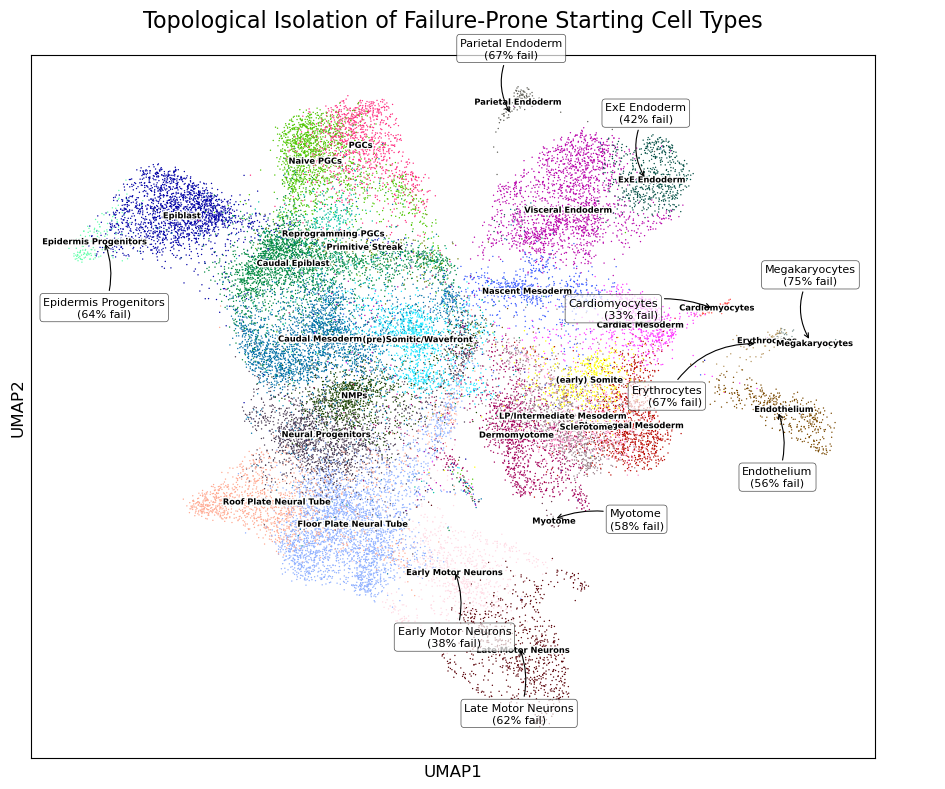

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from matplotlib.lines import Line2D
import os
import pickle

# ==============================================================================
# PART 1: LOAD DATA AND DEFINE FAILURE METRICS (Unchanged)
# ==============================================================================

if '_SHARED_ADATA' not in locals():
    print("Loading AnnData object...")
    data_path_new_data = os.path.join('../celloracle_data', "celloracle_object/new_promoter_without_mescs_trimmed_test_own_umap")
    adata_path = os.path.join(data_path_new_data, "adata.pkl")
    with open(adata_path, 'rb') as f:
        _SHARED_ADATA = pickle.load(f)
    print("...AnnData object loaded.")

failure_data = {
    'Megakaryocytes': 75.00, 'Erythrocytes': 66.67, 'Parietal Endoderm': 66.67,
    'Epidermis Progenitors': 63.89, 'Late Motor Neurons': 61.54, 'Myotome': 58.33,
    'Endothelium': 55.95, 'ExE Endoderm': 41.67, 'Early Motor Neurons': 38.19,
    'Cardiomyocytes': 33.33
}
failing_celltypes = list(failure_data.keys())

# ==============================================================================
# PART 2: HELPER FUNCTION TO FIND CLUSTER CENTERS (Unchanged)
# ==============================================================================
def calculate_cluster_centroids(adata, celltypes_to_find):
    centroids = {}
    embedding = adata.obsm["X_umap"]
    for celltype in celltypes_to_find:
        cell_mask = adata.obs["celltype"] == celltype
        cluster_coords = embedding[cell_mask]
        if cluster_coords.shape[0] > 0:
            centroids[celltype] = np.mean(cluster_coords, axis=0)
    return centroids

# ==============================================================================
# PART 3: THE FINAL, POLISHED PLOTTING FUNCTION
# ==============================================================================

def plot_umap_failure_highlights_final(
    adata,
    failure_rates,
    save_path=None,
    plot_title='Topological Isolation of Failure-Prone Starting Cell Types'
):
    """
    Generates a final publication-quality UMAP with clean annotations and no
    highlighting circles. Manually adjusts label positions to avoid overlap.
    """
    print("Generating final publication-quality UMAP plot...")

    # --- 1. Setup the plot with a white background ---
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    ax.set_facecolor('white')

    # --- 2. Generate the standard Scanpy UMAP with its legend ---
    sc.pl.umap(
        adata,
        color="celltype",
        frameon=True,
        show=False,
        title="", # Set title manually later
        ax=ax,
        legend_loc='on data',
        legend_fontsize=6,
        legend_fontoutline=2,
    )
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, fontsize='medium', ncol=1)

    # --- 3. Add Clean, Manually Positioned Annotations ---
    centroids = calculate_cluster_centroids(adata, failing_celltypes)

    # Define custom positions for annotations to avoid overlap
    # Format: ( (x_offset, y_offset), horizontal_alignment, connection_style_radius )
    annotation_positions = {
        'Megakaryocytes':       ((0, 40), 'center', 0.3),
        'Erythrocytes':         ((-40, -30), 'right', -0.3),
        'Parietal Endoderm':    ((0, 40), 'center', 0.3),
        'Epidermis Progenitors':((0, -40), 'center', 0.2), # *** MODIFIED LINE ***
        'Late Motor Neurons':   ((0, -40), 'center', 0.2),
        'Myotome':              ((40, 0), 'left', 0.2),
        'Endothelium':          ((0, -40), 'center', 0.2),
        'ExE Endoderm':         ((0, 40), 'center', 0.3),
        'Early Motor Neurons':  ((0, -40), 'center', 0.2),
        'Cardiomyocytes':       ((-40, 0), 'right', -0.2)
    }

    for celltype, centroid in centroids.items():
        rate = failure_rates[celltype]
        
        pos_config = annotation_positions.get(celltype, ((40, -40), 'left', 0.3))
        offset, ha, rad = pos_config

        # Determine vertical alignment based on offset
        # If text is below the point (negative y offset), align to top of text box
        if offset[1] < 0:
            va = 'top'
        # If text is above the point (positive y offset), align to bottom
        elif offset[1] > 0:
            va = 'bottom'
        # Otherwise, center it vertically
        else:
            va = 'center'

        # Add the annotation text box with an arrow
        ax.annotate(
            f"{celltype}\n({rate:.0f}% fail)",
            xy=centroid,
            xytext=offset,
            textcoords='offset points',
            ha=ha,
            va=va, # Use the dynamically set vertical alignment
            fontsize=8,
            color='black',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.7),
            arrowprops=dict(arrowstyle="->", color='black', connectionstyle=f"arc3,rad={rad}", lw=0.8)
        )

    # --- 4. Final plot aesthetics ---
    ax.set_title(plot_title, fontsize=16, color='black', pad=20)
    ax.set_xlabel('UMAP1', fontsize=12, color='black')
    ax.set_ylabel('UMAP2', fontsize=12, color='black')
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.tight_layout(rect=[0, 0, 0.8, 1]) # Adjust for legend

    # --- 5. Save the plot ---
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='white')
        print(f"Plot saved to: {save_path}")

    plt.show()
    plt.close(fig)

# ==============================================================================
# PART 4: CALL THE NEW FUNCTION
# ==============================================================================
if 'output_directory' not in locals():
    output_directory = './' 

plot_save_path_final = os.path.join(output_directory, "umap_failure_highlights_final_version.png")

plot_umap_failure_highlights_final(
    adata=_SHARED_ADATA,
    failure_rates=failure_data,
    save_path=plot_save_path_final
)

{'action_mask': MultiBinary(216), 'current_expression': Box(-100.0, 100.0, (3000,), float32), 'target_expression': Box(-100.0, 100.0, (3000,), float32)}

Figure saved successfully to: ../celloracle_data/models/final_optuna_please/path_comparison_white_bg.png


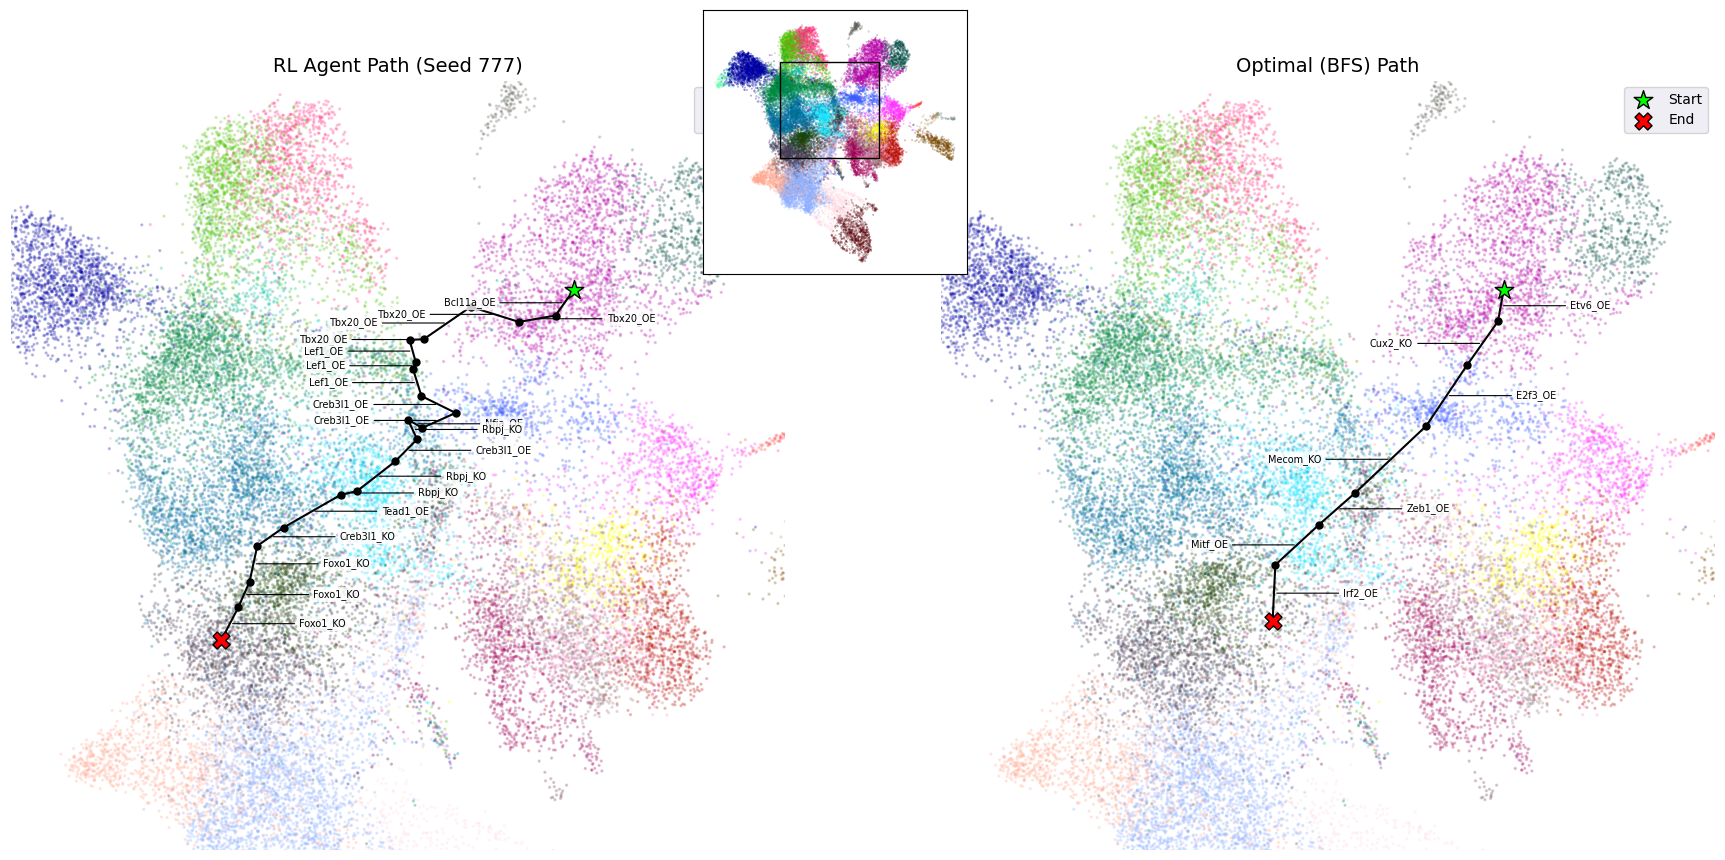

In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
# You might need to import PPO and graph if they are not already globally available
# from stable_baselines3 import PPO
# import networkx as nx

# This code assumes all previous setup cells have been run and that the following
# variables exist in your notebook's memory:
# - all_model_results_dfs, adata, env_logic, transition_matrix, target_nodes_dict,
#   get_shortest_bfs_path, perturbable_genes, MODEL_BASE_PATH, graph, PPO

# --- 1. Find the 22nd Best Example Episode ---
if 'all_model_results_dfs' not in locals() or not all_model_results_dfs:
    print("Error: 'all_model_results_dfs' not defined. Please run your evaluation loop first.")
else:
    final_results_df = pd.concat(all_model_results_dfs, ignore_index=True)
    candidate_episodes = final_results_df[(final_results_df['rl_success'] == True) & (final_results_df['bfs_success'] == True)].copy()

    if not candidate_episodes.empty:
        candidate_episodes['rl_path_length'] = pd.to_numeric(candidate_episodes['rl_path_length'])
        candidate_episodes['bfs_path_length'] = pd.to_numeric(candidate_episodes['bfs_path_length'])
        candidate_episodes['path_diff'] = abs(candidate_episodes['rl_path_length'] - candidate_episodes['bfs_path_length'])

        # --- Use episode 22 ---
        example_episode_index = 22
        if len(candidate_episodes) > example_episode_index:
            example_episode = candidate_episodes.sort_values(by='path_diff', ascending=False).iloc[example_episode_index]
        else:
            print(f"Warning: Only {len(candidate_episodes)} successful episodes available. Using the last one.")
            example_episode = candidate_episodes.sort_values(by='path_diff', ascending=False).iloc[-1]

        start_node = int(example_episode['start_node'])
        target_celltype = example_episode['target_celltype']
        model_seed = example_episode['model_seed']

        # --- 2. Re-simulate RL & BFS Paths (No changes here) ---
        model_path = os.path.join(MODEL_BASE_PATH, f"final_run_seed_{model_seed}", "final_model_gym.zip")
        model_to_use = PPO.load(model_path, device='cpu')
        rl_path_nodes, rl_actions = [start_node], []
        current_node = start_node
        target_expression_vector = env_logic.average_full_expression_vectors[target_celltype]
        for step in range(env_logic.max_steps):
            obs = {"current_expression": env_logic.AI_input[current_node], "target_expression": target_expression_vector, "action_mask": np.ones(env_logic.action_space.n)}
            action, _ = model_to_use.predict(obs, deterministic=True)
            next_node = transition_matrix[current_node, action.item()]
            if next_node != current_node: rl_path_nodes.append(next_node); rl_actions.append(action.item())
            if next_node in target_nodes_dict[target_celltype]: break
            current_node = next_node
        bfs_len, bfs_path_nodes, bfs_actions, _ = get_shortest_bfs_path(graph, start_node, target_nodes_dict[target_celltype])
        n_genes = len(perturbable_genes)
        action_names_dict = {i: f"{gene}_KO" for i, gene in enumerate(perturbable_genes)}; action_names_dict.update({i + n_genes: f"{gene}_OE" for i, gene in enumerate(perturbable_genes)})
        rl_action_labels = [action_names_dict.get(idx, "N/A") for idx in rl_actions]; bfs_action_labels = [action_names_dict.get(idx, "N/A") for idx in bfs_actions]


        # --- 3. Auto-Zoom and Rectangle Calculation ---
        combined_path_indices = np.unique(rl_path_nodes + bfs_path_nodes)
        path_coords_for_zoom = adata.obsm['X_umap'][combined_path_indices]

        padding_factor = 0.6
        min_x, max_x = path_coords_for_zoom[:, 0].min(), path_coords_for_zoom[:, 0].max()
        min_y, max_y = path_coords_for_zoom[:, 1].min(), path_coords_for_zoom[:, 1].max()
        x_range = max_x - min_x; y_range = max_y - min_y
        xlims = (min_x - x_range * padding_factor, max_x + x_range * padding_factor)
        ylims = (min_y - y_range * padding_factor, max_y + y_range * padding_factor)

        rect_padding = 0.5
        rect_xlims = (min_x - rect_padding, max_x + rect_padding)
        rect_ylims = (min_y - rect_padding, max_y + rect_padding)


        # --- 4. Plotting Function (White Background Version) ---
        def plot_path_on_umap(ax, adata, path_indices, action_labels, title, color_map, xlims, ylims):
            umap_coords = adata.obsm['X_umap']
            ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=2, alpha=0.20, c=[color_map.get(ct, 'gray') for ct in adata.obs['celltype']], rasterized=True)

            path_coords = umap_coords[path_indices]
            # Change path color to black
            ax.plot(path_coords[:, 0], path_coords[:, 1], 'o-', c='black', linewidth=1.5, markersize=5, zorder=10)

            for i in range(len(path_coords) - 1):
                mid_point = (path_coords[i] + path_coords[i+1]) / 2
                ha = 'left'; x_offset = 50; y_offset = 0; va = 'center'

                if "RL Agent Path" in title:
                    num_actions = len(action_labels)
                    if i == 1:
                        pass
                    elif i < num_actions - 10:
                        x_offset = -x_offset
                        ha = 'right'
                else: # BFS Path
                    if i % 2 != 0:
                        x_offset = -x_offset
                        ha = 'right'

                offset = (x_offset, y_offset)

                ax.annotate(action_labels[i],
                            xy=mid_point,
                            xytext=offset,
                            textcoords='offset points',
                            fontsize=7,
                            ha=ha,
                            va=va,
                            zorder=12,
                            # Change annotation box and text colors
                            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8, ec='none'),
                            arrowprops=dict(arrowstyle='-',
                                            connectionstyle='arc3,rad=0.0',
                                            color='black', lw=0.8),
                            color='black')

            ax.scatter(path_coords[0, 0], path_coords[0, 1], c='lime', s=200, marker='*', zorder=11, label='Start', edgecolors='black')
            ax.scatter(path_coords[-1, 0], path_coords[-1, 1], c='red', s=150, marker='X', zorder=11, label='End', edgecolors='black')
            ax.set_xlim(xlims); ax.set_ylim(ylims)
            # Change title color to black
            ax.set_title(title, fontsize=14, color='black')
            ax.set_xticks([]); ax.set_yticks([])
            legend = ax.legend();
            # Change legend text color to black
            for text in legend.get_texts(): text.set_color("black")

        # --- 5. Generate and Save the Final Figure with SHARED INSET ---
        celltype_categories = adata.obs['celltype'].cat.categories
        celltype_colors_list = adata.uns['celltype_colors']
        cell_type_color_map = {category: color for category, color in zip(celltype_categories, celltype_colors_list)}

        # Change figure facecolor to white
        fig = plt.figure(figsize=(22, 10), facecolor='white')

        ax_rl = fig.add_subplot(1, 2, 1); ax_bfs = fig.add_subplot(1, 2, 2)
        # Change axes facecolor to white
        ax_rl.set_facecolor('white'); ax_bfs.set_facecolor('white')

        plot_path_on_umap(ax_rl, adata, rl_path_nodes, rl_action_labels, f"RL Agent Path (Seed {model_seed})", cell_type_color_map, xlims, ylims)
        plot_path_on_umap(ax_bfs, adata, bfs_path_nodes, bfs_action_labels, "Optimal (BFS) Path", cell_type_color_map, xlims, ylims)

        # Inset creation logic
        fig_width, fig_height = fig.get_size_inches()
        fig_aspect = fig_width / fig_height
        inset_width = 0.12
        inset_height = inset_width * fig_aspect
        left = 0.5 - (inset_width / 2)
        bottom = 0.95 - inset_height

        ax_inset = fig.add_axes([left, bottom, inset_width, inset_height])
        umap_coords = adata.obsm['X_umap']
        ax_inset.scatter(umap_coords[:, 0], umap_coords[:, 1], s=0.1, alpha=0.5, c=[cell_type_color_map.get(ct, 'gray') for ct in adata.obs['celltype']], rasterized=True)

        # Change rectangle and spine colors to black
        rect = Rectangle((rect_xlims[0], rect_ylims[0]), rect_xlims[1] - rect_xlims[0], rect_ylims[1] - rect_ylims[0],
                         linewidth=1, edgecolor='black', facecolor='none', zorder=20)
        ax_inset.add_patch(rect)

        ax_inset.set_xticks([]); ax_inset.set_yticks([])
        ax_inset.set_facecolor('white')
        for spine in ax_inset.spines.values():
            spine.set_edgecolor('black')

        figure_path = os.path.join(MODEL_BASE_PATH, "path_comparison_white_bg.png")
        # The facecolor will be correctly picked up from the figure object
        plt.savefig(figure_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"\nFigure saved successfully to: {figure_path}")
        plt.show()

    else:
        print("\nCould not find a suitable episode where both RL and BFS succeeded to visualize.")

/tmp/ipykernel_1309408/1410305603.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


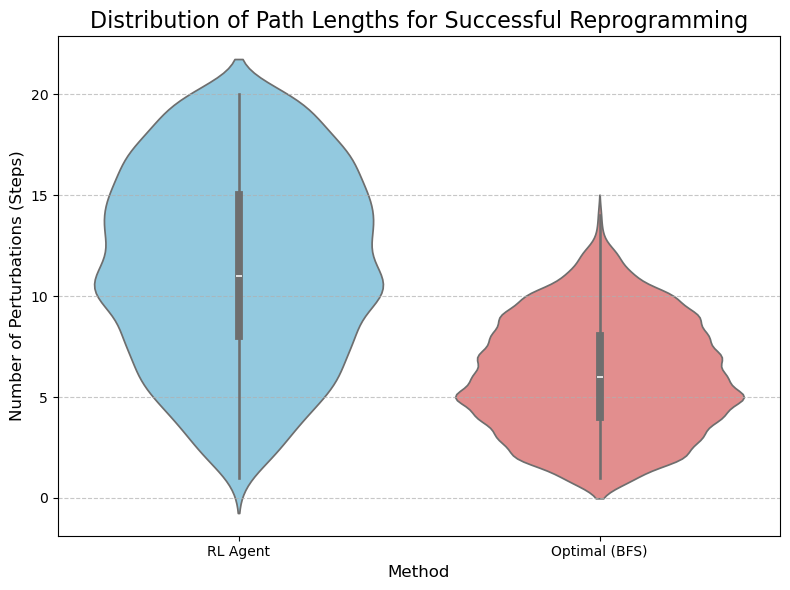

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Prepare the data for plotting ---
# We only want successful runs for this comparison
succeeded_df = final_results_df[
    (final_results_df['rl_success'] == True) &
    (final_results_df['bfs_success'] == True)
].copy()

# Create a "tidy" DataFrame suitable for seaborn
rl_data = succeeded_df[['rl_path_length']].rename(columns={'rl_path_length': 'Path Length'})
rl_data['Method'] = 'RL Agent'

bfs_data = succeeded_df[['bfs_path_length']].rename(columns={'bfs_path_length': 'Path Length'})
bfs_data['Method'] = 'Optimal (BFS)'

plot_df = pd.concat([rl_data, bfs_data])

# --- Create the plot ---
plt.style.use('default') # Use a standard white background style
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(
    data=plot_df,
    x='Method',
    y='Path Length',
    palette={'RL Agent': 'skyblue', 'Optimal (BFS)': 'lightcoral'},
    ax=ax
)

ax.set_title('Distribution of Path Lengths for Successful Reprogramming', fontsize=16)
ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Number of Perturbations (Steps)', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(output_directory, "path_length_distribution.png"), dpi=300)
plt.show()

In [ ]:
# collecting graph data:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Prepare the data for plotting ---

# Ensure we are using the variable name defined in the previous step
if 'final_results_df' not in locals():
    print("Error: final_results_df not found. Did the previous step run?")
else:
    # Note: Since we did a horizontal concat (axis=1), we might have duplicate column names
    # (e.g., 'start_node' appears in both RL and BFS dfs).
    # We remove duplicate columns just in case.
    final_results_df = final_results_df.loc[:, ~final_results_df.columns.duplicated()]

    # Filter for success
    succeeded_df = final_results_df[
        (final_results_df['rl_success'] == True) &
        (final_results_df['bfs_success'] == True)
    ].copy()

    print(f"Plotting {len(succeeded_df)} successful episodes out of {len(final_results_df)} total.")

    # Create a "tidy" DataFrame suitable for seaborn
    rl_data = succeeded_df[['rl_path_length']].rename(columns={'rl_path_length': 'Path Length'})
    rl_data['Method'] = 'RL Agent'

    bfs_data = succeeded_df[['bfs_path_length']].rename(columns={'bfs_path_length': 'Path Length'})
    bfs_data['Method'] = 'Optimal (BFS)'

    plot_df = pd.concat([rl_data, bfs_data])

    # --- Create the plot ---
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.violinplot(
        data=plot_df,
        x='Method',
        y='Path Length',
        palette={'RL Agent': 'skyblue', 'Optimal (BFS)': 'lightcoral'},
        ax=ax
    )

    ax.set_title('Distribution of Path Lengths for Successful Reprogramming', fontsize=16)
    ax.set_xlabel('Method', fontsize=12)
    ax.set_ylabel('Number of Perturbations (Steps)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    # Ensure output_directory is defined or remove the path join
    # plt.savefig("path_length_distribution.png", dpi=300)
    plt.show()

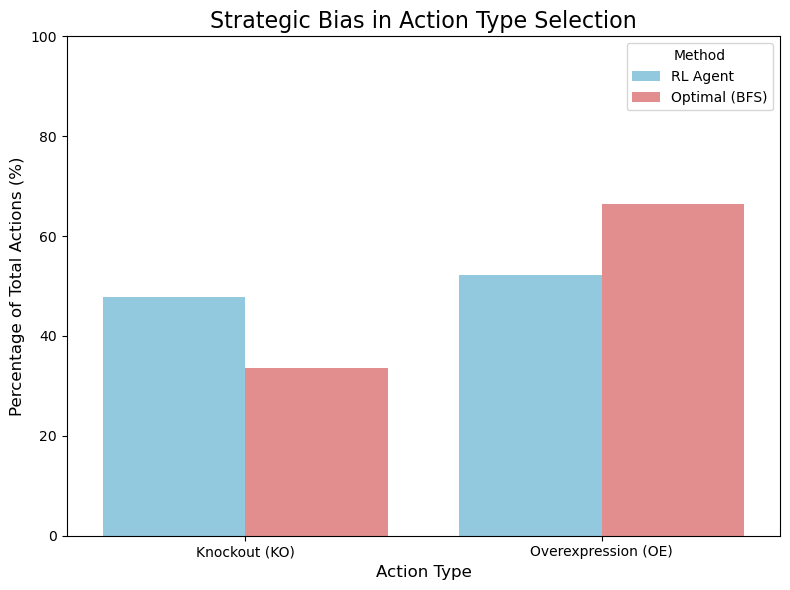

In [54]:
ko_rl_ratio = 47.76
oe_rl_ratio = 52.24
ko_bfs_ratio = 33.60
oe_bfs_ratio = 66.40

plot_data = {
    'Method': ['RL Agent', 'Optimal (BFS)', 'RL Agent', 'Optimal (BFS)'],
    'Action Type': ['Knockout (KO)', 'Knockout (KO)', 'Overexpression (OE)', 'Overexpression (OE)'],
    'Percentage': [ko_rl_ratio, ko_bfs_ratio, oe_rl_ratio, oe_bfs_ratio]
}
plot_df = pd.DataFrame(plot_data)

# --- Create the plot ---
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=plot_df,
    x='Action Type',
    y='Percentage',
    hue='Method',
    palette={'RL Agent': 'skyblue', 'Optimal (BFS)': 'lightcoral'},
    ax=ax
)

ax.set_title('Strategic Bias in Action Type Selection', fontsize=16)
ax.set_xlabel('Action Type', fontsize=12)
ax.set_ylabel('Percentage of Total Actions (%)', fontsize=12)
ax.set_ylim(0, 100)
ax.legend(title='Method')

plt.tight_layout()
plt.savefig(os.path.join(output_directory, "action_type_bias.png"), dpi=300)
plt.show()

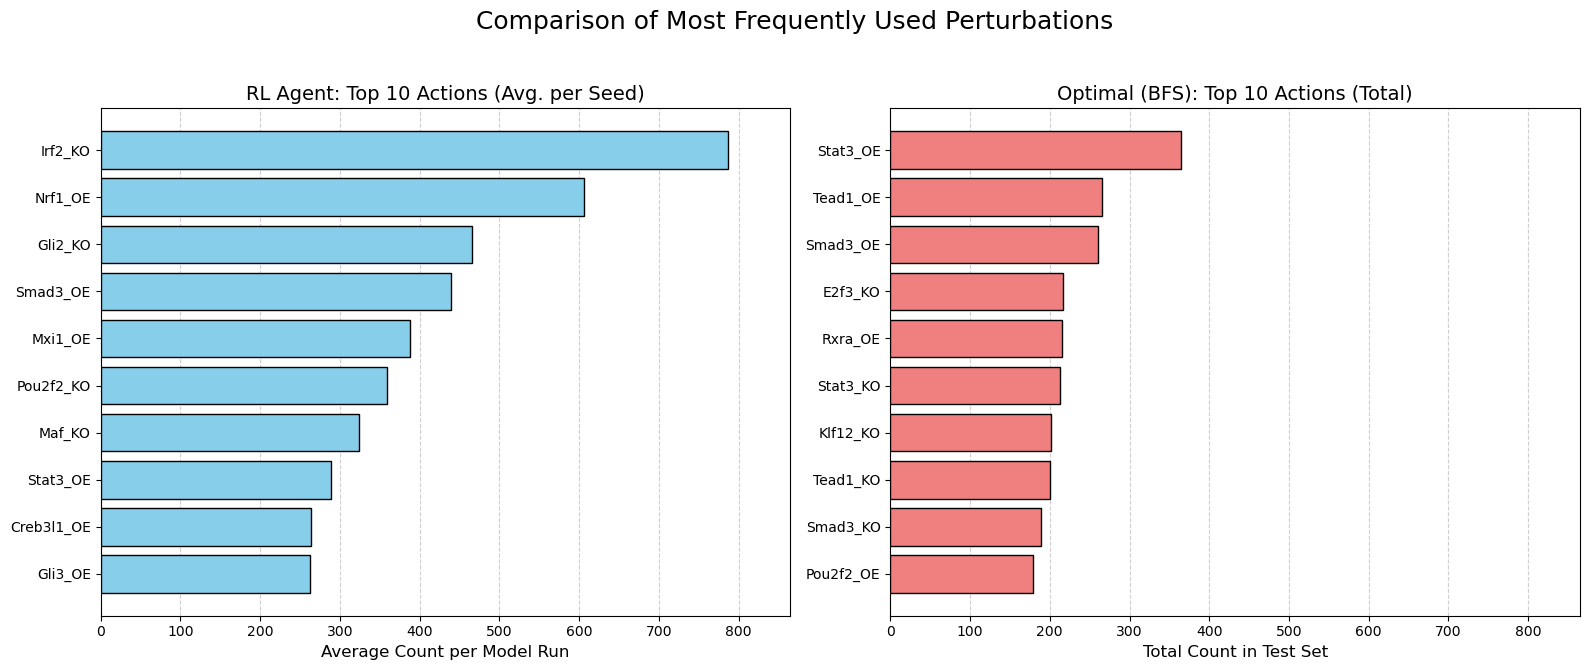

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import itertools

# --- 1. Prepare the Data (Self-Contained) ---
# This code now calculates everything it needs from the 'final_results_df' DataFrame.

# Ensure 'final_results_df' exists from your evaluation run.
if 'final_results_df' not in locals():
    print("Error: 'final_results_df' is not defined. Please run the evaluation and analysis script first.")
else:
    # Use only the cohort where both methods succeeded for a fair comparison
    succeeded_df = final_results_df[
        (final_results_df['rl_success'] == True) &
        (final_results_df['bfs_success'] == True)
    ].copy()

    # Get the number of unique model seeds for averaging
    num_seeds = succeeded_df['model_seed'].nunique()

    # Re-create the action_names_map
    n_genes = len(perturbable_genes)
    action_names_map = {i: f"{gene}_KO" for i, gene in enumerate(perturbable_genes)}
    action_names_map.update({i + n_genes: f"{gene}_OE" for i, gene in enumerate(perturbable_genes)})

    # Calculate the total action counts for RL
    all_rl_actions = list(itertools.chain.from_iterable(succeeded_df['rl_actions']))
    rl_action_counts = Counter(all_rl_actions)

    # Calculate the total action counts for BFS (from unique episodes)
    unique_bfs_succeeded_df = succeeded_df.drop_duplicates(subset=['start_node', 'target_celltype'])
    all_bfs_actions = list(itertools.chain.from_iterable(unique_bfs_succeeded_df['bfs_actions']))
    bfs_action_counts = Counter(all_bfs_actions)

    # Get the top 10 most common for each
    top_rl = rl_action_counts.most_common(10)
    top_bfs = bfs_action_counts.most_common(10)

    # Prepare labels and values for plotting
    rl_labels = [action_names_map[act] for act, count in top_rl]
    rl_values = [count / num_seeds for act, count in top_rl] # Average count

    bfs_labels = [action_names_map[act] for act, count in top_bfs]
    bfs_values = [count for act, count in top_bfs] # Total count

    # --- 2. Create the Plot ---
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7)) # Slightly wider for long labels

    # RL Agent Plot
    ax1.barh(y=rl_labels, width=rl_values, color='skyblue', edgecolor='black', zorder=3)
    ax1.set_title('RL Agent: Top 10 Actions (Avg. per Seed)', fontsize=14)
    ax1.set_xlabel('Average Count per Model Run', fontsize=12)
    ax1.invert_yaxis() # To display the top item at the top
    ax1.grid(axis='x', linestyle='--', alpha=0.6, zorder=0)

    # BFS Plot
    ax2.barh(y=bfs_labels, width=bfs_values, color='lightcoral', edgecolor='black', zorder=3)
    ax2.set_title('Optimal (BFS): Top 10 Actions (Total)', fontsize=14)
    ax2.set_xlabel('Total Count in Test Set', fontsize=12)
    ax2.invert_yaxis()
    ax2.grid(axis='x', linestyle='--', alpha=0.6, zorder=0)

    # Share the x-axis for easier comparison of magnitude
    max_val = max(max(rl_values), max(bfs_values))
    ax1.set_xlim(0, max_val * 1.1)
    ax2.set_xlim(0, max_val * 1.1)

    fig.suptitle('Comparison of Most Frequently Used Perturbations', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.savefig(os.path.join(output_directory, "top_10_actions.png"), dpi=300)
    plt.show()


--- Descriptive Statistics for Jaccard Similarity (%) ---
count    4635.000000
mean        8.425719
std         7.010381
min         2.941176
25%         4.545455
50%         6.250000
75%         9.090909
max        83.333333
Name: jaccard_similarity_pct, dtype: float64


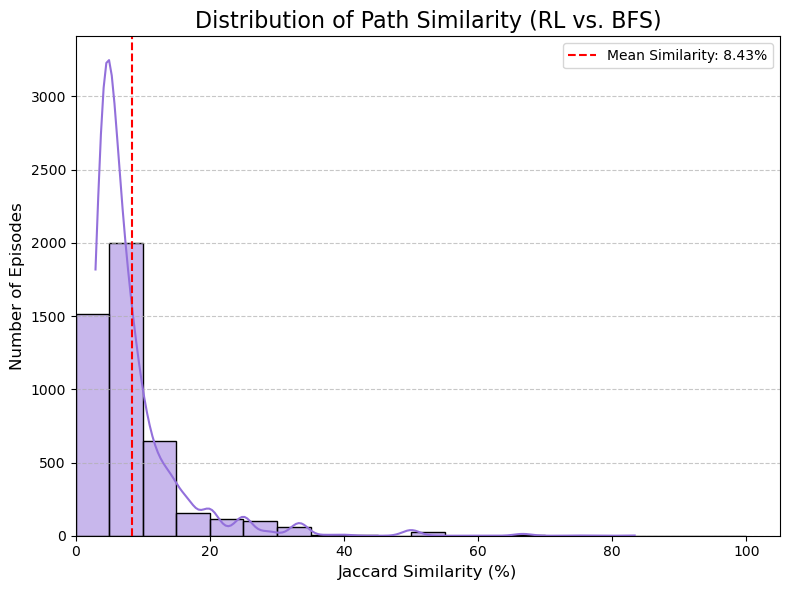


Figure 4 generated successfully with corrected range.


In [37]:
# ==============================================================================
# PART 2: PLOTTING FIGURE 4 (JACCARD SIMILARITY) - CORRECTED
# ==============================================================================
import seaborn as sns

# Create the 'succeeded_df' by filtering
succeeded_df = final_results_df[
    (final_results_df['rl_success'] == True) &
    (final_results_df['bfs_success'] == True)
].copy()

# Define the function to calculate Jaccard similarity
def calculate_jaccard(row):
    set_rl = set(row['rl_path_nodes'])
    set_bfs = set(row['bfs_path_nodes'])
    intersection = len(set_rl.intersection(set_bfs))
    union = len(set_rl.union(set_bfs))
    return intersection / union if union > 0 else 0

# Apply the function to create the similarity column
succeeded_df['jaccard_similarity'] = succeeded_df.apply(calculate_jaccard, axis=1)
succeeded_df['jaccard_similarity_pct'] = succeeded_df['jaccard_similarity'] * 100

# *** OPTIONAL BUT RECOMMENDED: VERIFY THE DATA ***
print("\n--- Descriptive Statistics for Jaccard Similarity (%) ---")
print(succeeded_df['jaccard_similarity_pct'].describe())


# Create the Plot
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))

# *** THE FIX IS APPLIED HERE WITH binrange=(0, 100) ***
sns.histplot(data=succeeded_df, x='jaccard_similarity_pct', kde=True, bins=20, binrange=(0, 100), color='mediumpurple', ax=ax)

mean_sim = succeeded_df['jaccard_similarity_pct'].mean()
ax.axvline(mean_sim, color='red', linestyle='--', label=f'Mean Similarity: {mean_sim:.2f}%')
ax.set_title('Distribution of Path Similarity (RL vs. BFS)', fontsize=16)
ax.set_xlabel('Jaccard Similarity (%)', fontsize=12)
ax.set_ylabel('Number of Episodes', fontsize=12)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Force the x-axis to start exactly at 0 for clarity
ax.set_xlim(left=0)

plt.tight_layout()
plt.savefig(os.path.join(output_directory, "jaccard_similarity_distribution_corrected.png"), dpi=300)
plt.show()
print("\nFigure 4 generated successfully with corrected range.")

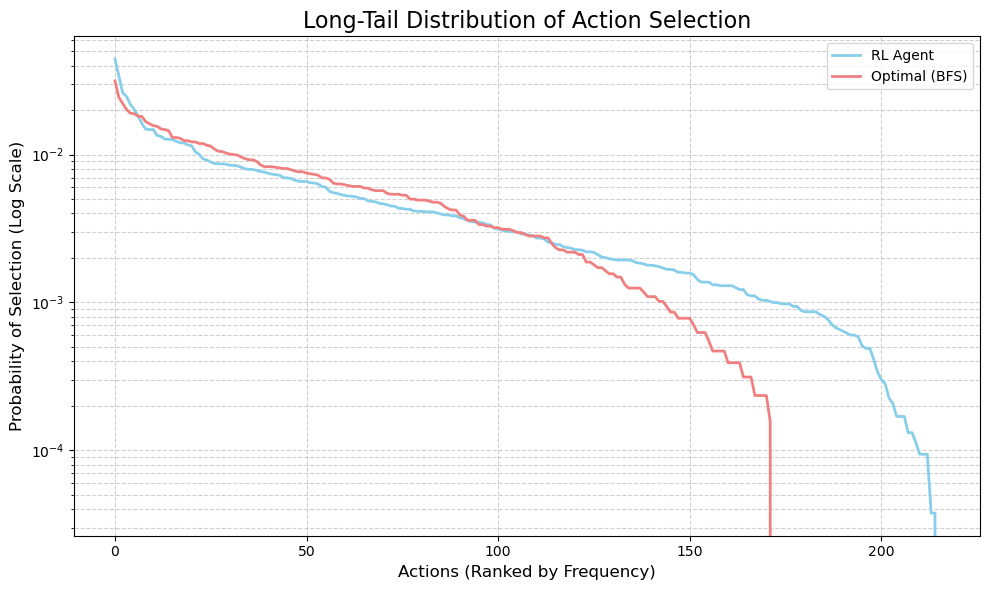

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Load the data ---
# Assumes 'output_directory' is defined from your analysis script
csv_path = os.path.join(output_directory, "action_distribution.csv")
dist_df = pd.read_csv(csv_path)

# --- Prepare data for plotting ---
# Sort by probability for each method
rl_sorted = dist_df['RL_Probability'].sort_values(ascending=False).reset_index(drop=True)
bfs_sorted = dist_df['BFS_Probability'].sort_values(ascending=False).reset_index(drop=True)

# --- Create the plot ---
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(rl_sorted.index, rl_sorted.values, label='RL Agent', color='skyblue', lw=2)
ax.plot(bfs_sorted.index, bfs_sorted.values, label='Optimal (BFS)', color='lightcoral', lw=2)

# Using a log scale on the y-axis is crucial for seeing the "tail"
ax.set_yscale('log')

ax.set_title('Long-Tail Distribution of Action Selection', fontsize=16)
ax.set_xlabel('Actions (Ranked by Frequency)', fontsize=12)
ax.set_ylabel('Probability of Selection (Log Scale)', fontsize=12)
ax.grid(True, which='both', linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_directory, "action_distribution_long_tail.png"), dpi=300)
plt.show()

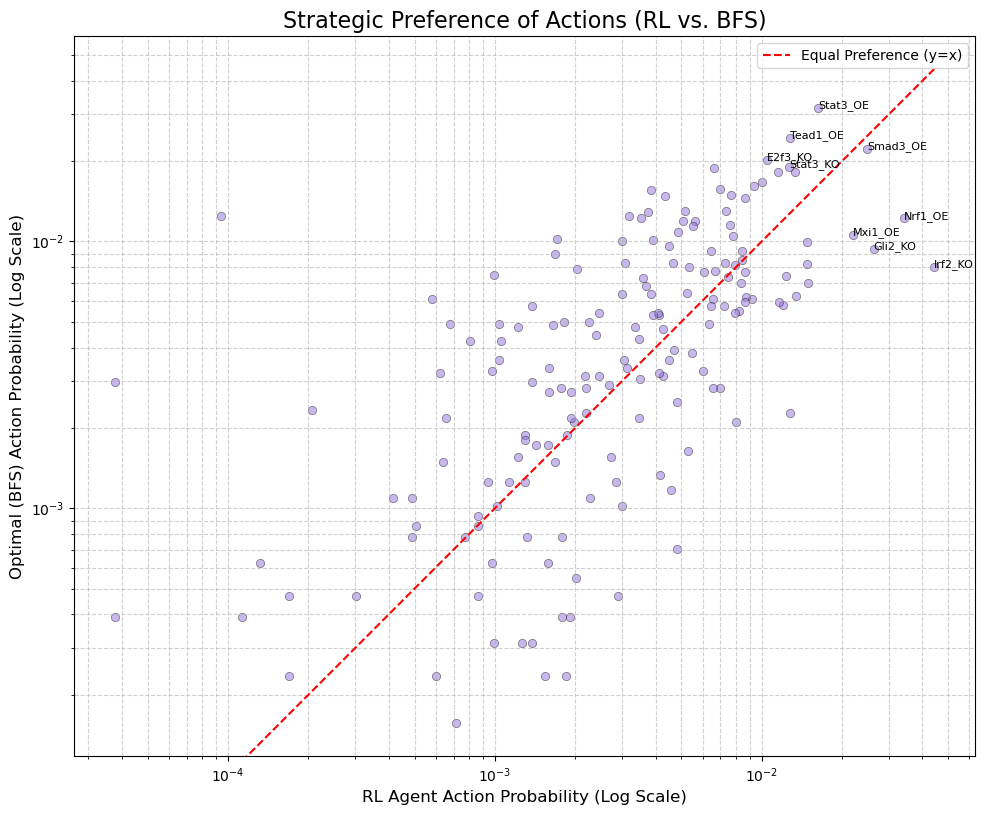

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Load the data ---
csv_path = os.path.join(output_directory, "action_distribution.csv")
dist_df = pd.read_csv(csv_path)

# --- Create the plot ---
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot of all 216 actions
ax.scatter(
    dist_df['RL_Probability'],
    dist_df['BFS_Probability'],
    alpha=0.5,
    color='mediumpurple',
    edgecolors='black',
    linewidth=0.5
)

# Add the diagonal y=x line for reference
max_prob = max(dist_df['RL_Probability'].max(), dist_df['BFS_Probability'].max())
ax.plot([0, max_prob], [0, max_prob], color='red', linestyle='--', label='Equal Preference (y=x)')

# Use a log scale to better visualize points clustered near the origin
ax.set_xscale('log')
ax.set_yscale('log')

# --- Annotate the most important/divergent points ---
# Get top 5 preferred actions for each method
rl_preferred = dist_df.sort_values(by='RL_Probability', ascending=False).head(5)
bfs_preferred = dist_df.sort_values(by='BFS_Probability', ascending=False).head(5)
points_to_label = pd.concat([rl_preferred, bfs_preferred]).drop_duplicates()

for i, row in points_to_label.iterrows():
    ax.text(row['RL_Probability'], row['BFS_Probability'], row['ActionName'], fontsize=8)

ax.set_title('Strategic Preference of Actions (RL vs. BFS)', fontsize=16)
ax.set_xlabel('RL Agent Action Probability (Log Scale)', fontsize=12)
ax.set_ylabel('Optimal (BFS) Action Probability (Log Scale)', fontsize=12)
ax.grid(True, which='both', linestyle='--', alpha=0.6)
ax.legend()
ax.set_aspect('equal') # Ensure the plot is a square for correct diagonal interpretation

plt.tight_layout()
plt.savefig(os.path.join(output_directory, "action_preference_scatter.png"), dpi=300)
plt.show()

Selected episode: Start Node 14868 (Caudal Mesoderm) -> Target 'LP/Intermediate Mesoderm' using model seed 7777
{'action_mask': MultiBinary(216), 'current_expression': Box(-100.0, 100.0, (3000,), float32), 'target_expression': Box(-100.0, 100.0, (3000,), float32)}


/tmp/ipykernel_1309408/1412597149.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(unique_cell_types))



Figure saved successfully to: ../celloracle_data/models/final_optuna_please/path_comparison_with_actions.png


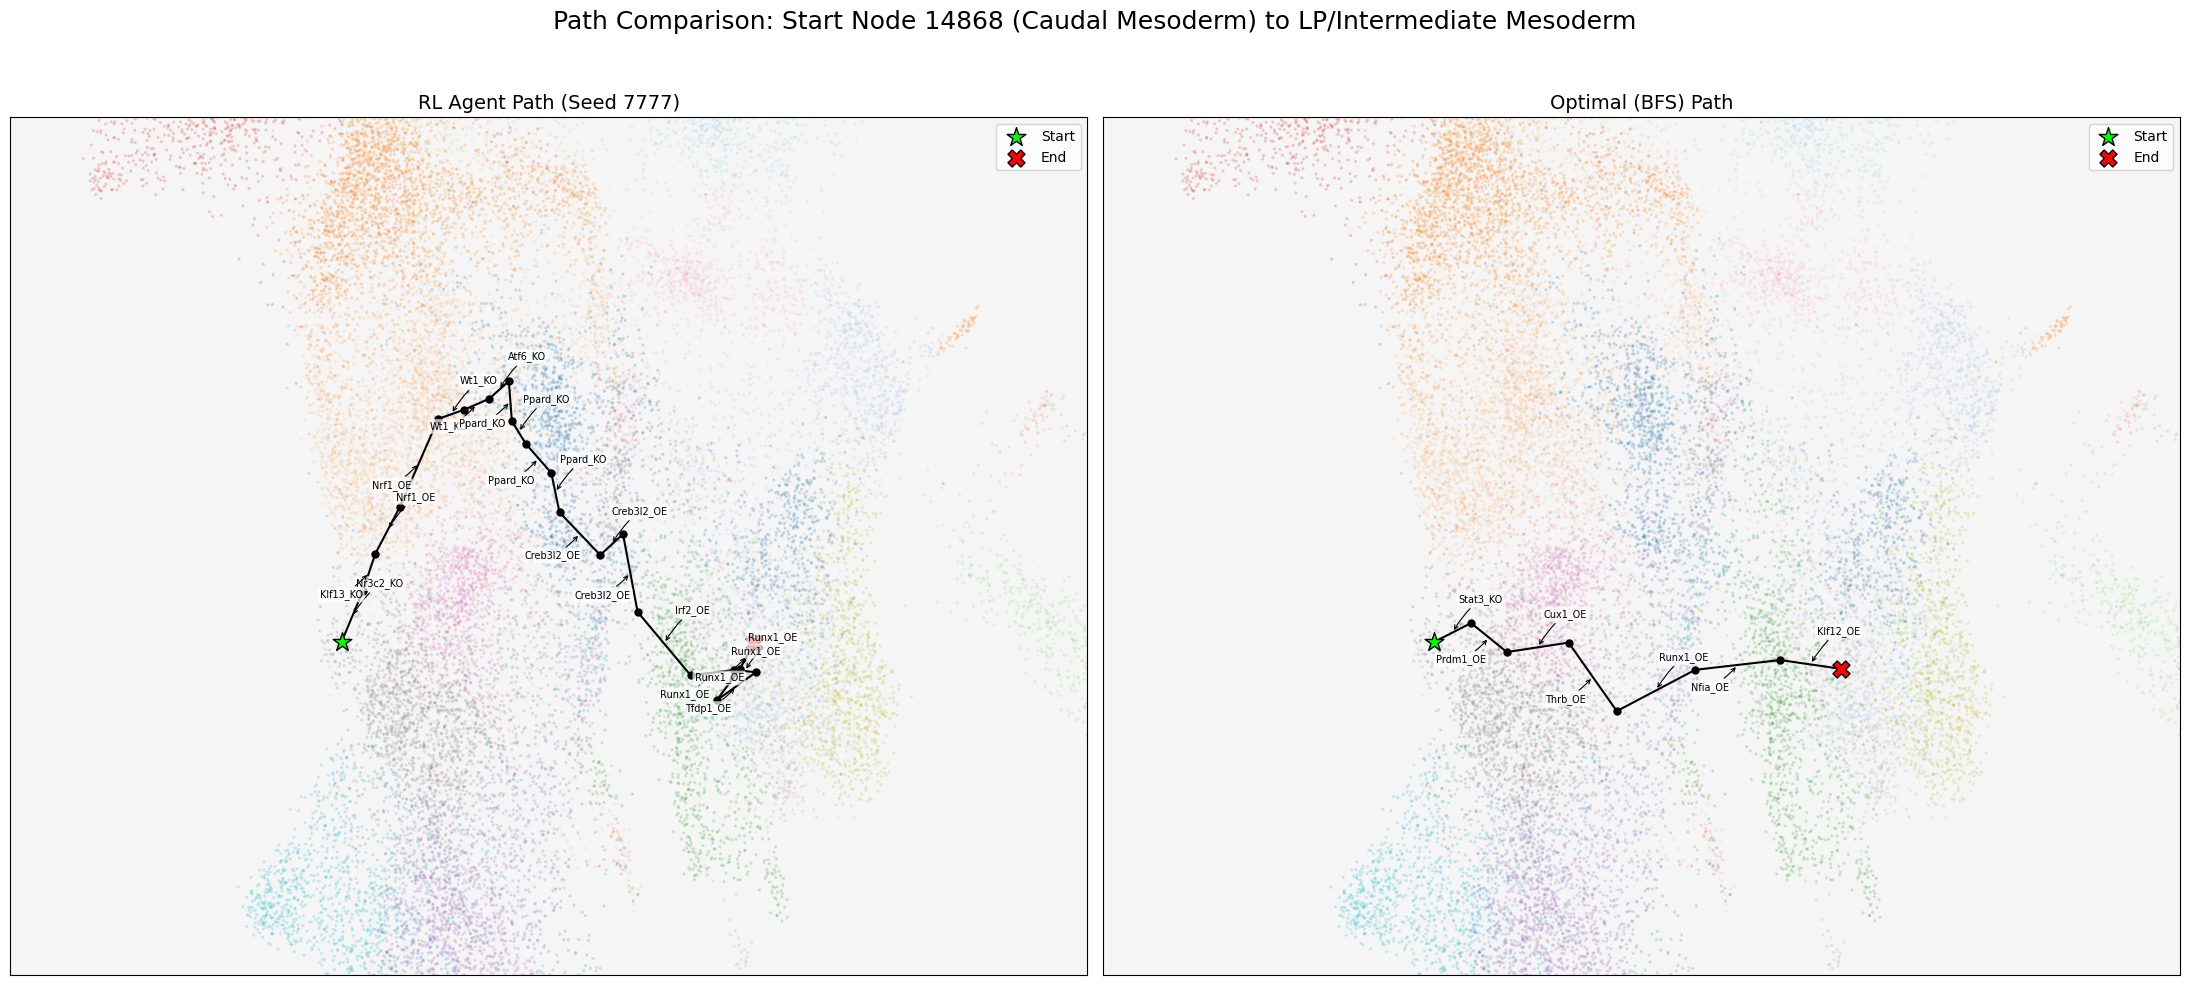

In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import numpy as np
import pandas as pd

# This assumes all previous cells (data loading, env setup, etc.) have been run

# --- 1. Find the 20th Best Example Episode ---
if not all_model_results_dfs:
    print("No model results to analyze. Please run the evaluation loop first.")
else:
    final_results_df = pd.concat(all_model_results_dfs, ignore_index=True)

candidate_episodes = final_results_df[
    (final_results_df['rl_success'] == True) &
    (final_results_df['bfs_success'] == True)
].copy()

if not candidate_episodes.empty:
    candidate_episodes['rl_path_length'] = pd.to_numeric(candidate_episodes['rl_path_length'])
    candidate_episodes['bfs_path_length'] = pd.to_numeric(candidate_episodes['bfs_path_length'])
    candidate_episodes['path_diff'] = abs(candidate_episodes['rl_path_length'] - candidate_episodes['bfs_path_length'])

    example_episode = candidate_episodes.sort_values(by='path_diff', ascending=False).iloc[20]

    start_node = int(example_episode['start_node'])
    target_celltype = example_episode['target_celltype']
    model_seed = example_episode['model_seed']

    print(f"Selected episode: Start Node {start_node} ({adata.obs['celltype'].iloc[start_node]}) -> Target '{target_celltype}' using model seed {model_seed}")

    # --- 2. Re-simulate RL Path ---
    model_path = os.path.join(MODEL_BASE_PATH, f"final_run_seed_{model_seed}", "final_model_gym.zip")
    model_to_use = PPO.load(model_path, device='cpu')
    rl_path_nodes, rl_actions = [start_node], []
    current_node = start_node
    target_expression_vector = env_logic.average_full_expression_vectors[target_celltype]

    for step in range(env_logic.max_steps):
        obs = {"current_expression": env_logic.AI_input[current_node], "target_expression": target_expression_vector, "action_mask": np.ones(env_logic.action_space.n)}
        action, _ = model_to_use.predict(obs, deterministic=True)
        next_node = transition_matrix[current_node, action.item()]
        if next_node != current_node:
            rl_path_nodes.append(next_node)
            rl_actions.append(action.item())
        if next_node in target_nodes_dict[target_celltype]: break
        current_node = next_node

    # --- 3. Find the Optimal (BFS) Path ---
    bfs_len, bfs_path_nodes, bfs_actions, _ = get_shortest_bfs_path(graph, start_node, target_nodes_dict[target_celltype])

    # --- 4. Convert action indices to names ---
    n_genes = len(perturbable_genes)
    action_names_dict = {i: f"{gene}_KO" for i, gene in enumerate(perturbable_genes)}
    action_names_dict.update({i + n_genes: f"{gene}_OE" for i, gene in enumerate(perturbable_genes)})
    rl_action_labels = [action_names_dict.get(idx, "N/A") for idx in rl_actions]
    bfs_action_labels = [action_names_dict.get(idx, "N/A") for idx in bfs_actions]

    # --- 5. Modified Auto-Zoom Calculation ---
    combined_path_indices = np.unique(rl_path_nodes + bfs_path_nodes)
    path_coords_for_zoom = adata.obsm['X_umap'][combined_path_indices]
    min_x, max_x = path_coords_for_zoom[:, 0].min(), path_coords_for_zoom[:, 0].max()
    min_y, max_y = path_coords_for_zoom[:, 1].min(), path_coords_for_zoom[:, 1].max()

    ## CHANGE 1: INCREASED PADDING TO ZOOM OUT SIGNIFICANTLY
    padding_factor = 0.8  # Was 0.25. Feel free to make this even larger (e.g., 1.2) for a wider view.

    x_range = max_x - min_x
    y_range = max_y - min_y
    xlims = (min_x - x_range * padding_factor, max_x + x_range * padding_factor)
    ylims = (min_y - y_range * padding_factor, max_y + y_range * padding_factor)

    # --- 6. ENHANCED and CORRECTED Plotting Function ---
    def plot_path_on_umap(ax, adata, path_indices, action_labels, title, color_map, xlims, ylims):
        umap_coords = adata.obsm['X_umap']
        cell_types = adata.obs['celltype']

        ## CHANGE 2: INCREASED ALPHA FOR A CLEARER BACKGROUND
        ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=2, alpha=0.3, c=[color_map.get(ct, 'white') for ct in cell_types], rasterized=True)

        if not path_indices or len(path_indices) < 2:
            ax.set_title(title, fontsize=14); return

        path_coords = umap_coords[path_indices]
        ax.plot(path_coords[:, 0], path_coords[:, 1], 'o-', c='black', linewidth=1.5, markersize=5, zorder=10)

        for i in range(len(path_coords) - 1):
            mid_point = (path_coords[i] + path_coords[i+1]) / 2
            offset = (20, 20) if i % 2 == 0 else (-20, -20)
            ax.annotate(action_labels[i], xy=mid_point, xytext=offset,
                        textcoords='offset points', fontsize=7, ha='center', va='bottom', zorder=12,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, ec='none'),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1', color='black', lw=0.8))

        ax.scatter(path_coords[0, 0], path_coords[0, 1], c='lime', s=200, marker='*', zorder=11, label='Start', edgecolors='black')
        ax.scatter(path_coords[-1, 0], path_coords[-1, 1], c='red', s=150, marker='X', zorder=11, label='End', edgecolors='black')

        ax.set_xlim(xlims)
        ax.set_ylim(ylims)

        ax.set_title(title, fontsize=14, color='black')
        ax.set_xticks([]); ax.set_yticks([])
        legend = ax.legend()
        for text in legend.get_texts(): text.set_color("black")

    # --- 7. Generate and Save the Final Figure ---
    unique_cell_types = sorted(adata.obs['celltype'].unique())
    colors = cm.get_cmap('tab20', len(unique_cell_types))
    cell_type_color_map = {ct: colors(i) for i, ct in enumerate(unique_cell_types)}

    fig, axes = plt.subplots(1, 2, figsize=(22, 10), facecolor='white')
    axes[0].set_facecolor('whitesmoke'); axes[1].set_facecolor('whitesmoke')

    plot_path_on_umap(axes[0], adata, rl_path_nodes, rl_action_labels, f"RL Agent Path (Seed {model_seed})", cell_type_color_map, xlims, ylims)
    plot_path_on_umap(axes[1], adata, bfs_path_nodes, bfs_action_labels, "Optimal (BFS) Path", cell_type_color_map, xlims, ylims)

    fig.suptitle(f"Path Comparison: Start Node {start_node} ({adata.obs['celltype'].iloc[start_node]}) to {target_celltype}", fontsize=18, color='black')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    figure_path = os.path.join(MODEL_BASE_PATH, "path_comparison_with_actions.png")
    plt.savefig(figure_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nFigure saved successfully to: {figure_path}")
    plt.show()

else:
    print("\nCould not find a suitable episode where both RL and BFS succeeded to visualize.")

In [19]:


results_list = []
all_model_summaries = []

for run_folder in RUN_FOLDER_NAMES:
    print("\n" + "="*80)
    print(f"STARTING EVALUATION FOR MODEL: {run_folder}")
    print("="*80)
    
    # --- Load the current model ---
    model_path = os.path.join(MODEL_BASE_PATH, run_folder, "final_model_gym.zip")
    assert os.path.exists(model_path), f"Model not found for run: {run_folder}"
    model = PPO.load(model_path, device='cpu')
    print(f"Successfully loaded model from {run_folder}")

    # --- Run evaluation loop for this model ---
    results_list = []
    for episode_data in test_episodes:
        # Extract start and target info
        start_obs = episode_data
        start_node = np.where((env_logic.AI_input == start_obs["current_expression"]).all(axis=1))[0][0]
        target_celltype = [k for k, v in env_logic.average_full_expression_vectors.items() if np.array_equal(v, start_obs["target_expression"])][0]
        
        # --- 1. Calculate RL Agent's Path Length ---
        rl_path_length = -1
        rl_success = False
        actions_taken = []
        
        current_node = start_node
        current_obs = start_obs
        
        for step in range(1, 21):
            # The observation must be wrapped in a dictionary for the action mask
            obs_for_predict = {
                "current_expression": current_obs["current_expression"],
                "target_expression": current_obs["target_expression"],
                "action_mask": np.ones(env_logic.action_space.n) # Mask doesn't matter for predict
            }
            action, _ = model.predict(obs_for_predict, deterministic=True)
            actions_taken.append(action.item())
            next_node = transition_matrix[current_node, action.item()]
            
            # Check for success
            if next_node in target_nodes_dict[target_celltype]:
                rl_path_length = step
                rl_success = True
                break
            
            # Update for next step
            current_node = next_node
            current_obs = {
                 "current_expression": env_logic.AI_input[current_node],
                 "target_expression": start_obs["target_expression"],
            }
        
        # --- 2. Calculate Optimal (BFS) Path Length ---
        valid_target_nodes = target_nodes_dict[target_celltype]
        bfs_path_length, bfs_path_nodes, bfs_success = get_bfs_path_length(graph, start_node, valid_target_nodes)
    
        # --- 3. Store Results ---
        if rl_success: # Only analyze optimality for successful runs
            results_list.append({
            "start_node": start_node,
            "target_celltype": target_celltype,
            "rl_success": rl_success,
            "rl_path_length": rl_path_length if rl_success else env_logic.max_steps,
            "rl_actions": actions_taken if rl_success else [],
            "bfs_success": bfs_success, # NEW
            "bfs_path_length": bfs_path_length,
            "bfs_path": bfs_path_nodes, # NEW
            })

print("Evaluation loop complete.")


# ===================================================================
# CELL 6: ANALYZE AND DISPLAY RESULTS
# ===================================================================
results_df = pd.DataFrame(results_list)

# Separate successful and failed runs
successful_runs_df = results_df[results_df['rl_success'] == True].copy()
failed_runs_df = results_df[results_df['rl_success'] == False]

# --- Core Performance Metrics ---
total_episodes = len(results_df)
total_successes = len(successful_runs_df)
success_rate = total_successes / total_episodes if total_episodes > 0 else 0

# --- NEW: Theoretical Solvability ---
bfs_solvable_count = results_df['bfs_success'].sum()
bfs_solvable_rate = bfs_solvable_count / total_episodes if total_episodes > 0 else 0

# --- Analysis of SUCCESSFUL Runs Only ---
if not successful_runs_df.empty:
    mean_rl_length = successful_runs_df['rl_path_length'].mean()
    valid_bfs_paths = successful_runs_df[successful_runs_df['bfs_path_length'] != float('inf')]
    mean_bfs_length = valid_bfs_paths['bfs_path_length'].mean() if not valid_bfs_paths.empty else float('nan')
    
    successful_runs_df['optimality_ratio'] = valid_bfs_paths['bfs_path_length'] / successful_runs_df['rl_path_length']
    mean_optimality = successful_runs_df['optimality_ratio'].mean()

    # Analyze Action Usage
    n_genes = len(perturbable_genes)
    action_names = {i: f"{gene}_KO" for i, gene in enumerate(perturbable_genes)}
    action_names.update({i + n_genes: f"{gene}_OE" for i, gene in enumerate(perturbable_genes)})
    all_actions_list = list(itertools.chain.from_iterable(successful_runs_df['rl_actions']))
    action_counts = Counter(all_actions_list)
    most_common_actions = {action_names[idx]: count for idx, count in action_counts.most_common(15)}

# --- Display Final Summary ---
print("\n" + "="*60)
print("           COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*60)
print(f"Total Test Episodes Evaluated: {total_episodes}")
print(f"Theoretically Solvable (BFS Path Exists): {bfs_solvable_count} ({bfs_solvable_rate:.2%})")
print("-" * 60)
print(f"RL Agent Successful Paths Found: {total_successes}")
print(f"RL Agent Overall Success Rate:   {success_rate:.2%}")
print("="*60)

if not successful_runs_df.empty:
    print("\n--- Analysis of Successful Paths ---")
    print(f"Average RL Agent Path Length:      {mean_rl_length:.2f} steps")
    print(f"Average Optimal (BFS) Path Length: {mean_bfs_length:.2f} steps")
    print(f"Average Path Optimality Ratio:     {mean_optimality:.3f} (closer to 1.0 is better)")
    
    print("\n--- Top 15 Most Frequent Actions in Successful Paths ---")
    for action, count in most_common_actions.items():
        print(f"  {action:<25}: {count} times")
    
    print("\n--- Sample of Successful Runs (with BFS path info) ---")
    # Display the most relevant columns, including the new ones
    print(successful_runs_df[[
        'start_node', 'target_celltype', 'rl_path_length', 
        'bfs_success', 'bfs_path_length', 'optimality_ratio'
    ]].head())
else:
    print("\nNo successful RL paths were found in the test set.")

print("\n" + "="*60)


STARTING EVALUATION FOR MODEL: final_run_seed_77


AssertionError: Model not found for run: final_run_seed_77

In [ ]:
transition_path = os.path.join('../celloracle_data', "transition_matrix")
data_path = os.path.join('../celloracle_data', "celloracle_object/new_promoter_without_mescs_trimmed_test_own_umap")
ORACLE_PATH = os.path.join(data_path, "ready_oracle.pkl")
TRANSITION_MATRIX_PATH = os.path.join(transition_path, "transition_matrix.pkl") 

with open(TRANSITION_MATRIX_PATH, 'rb') as f:
    transition_matrix = pickle.load(f)

with open(ORACLE_PATH, 'rb') as f:
    oracle = pickle.load(f)
    
genes_that_can_be_perturbed = oracle.return_active_reg_genes()
number_of_reg_genes = len(genes_that_can_be_perturbed)
celltypes_unique = oracle.adata.obs['celltype'].unique()
all_cell_types = oracle.adata.obs['celltype']

celltype_to_idx_dict = {}
for i, celltype in enumerate(celltypes_unique):
    celltype_to_idx_dict[celltype] = list(np.where(all_cell_types == celltype)[0])
    
#start with igraph
graph = ig.Graph(n=len(oracle.adata), directed=True)
edge_list  = []
action_idx = []
for i in range(len(oracle.adata)):
    for j in range(len(action_array)):
        next_node_idx = int(transition_matrix[i,j])
        edge_list.append((i, next_node_idx))
        action_idx.append(j)
        
graph.add_edges(edge_list)
graph.es['action_idx'] = action_idx



In [ ]:
def find_shortest_path(graph:ig.Graph, start_node: int, target_celltype:str, celltype_to_idx_dict:dict, genes_that_can_be_perturbed: Optional[List[str]]) -> Tuple[List[int], List[int]]:
    try:
        target_nodes = celltype_to_idx_dict[target_celltype]
        #convert to ints
        target_nodes = [int(i) for i in target_nodes]
        path_to_target  = graph.get_shortest_paths(start_node, to=target_nodes, output='epath', weight=None, mode = "OUT")
        
        if path_to_target is None:
            return [], []
        
        min_length = float('inf')
        shortest_path = None
        for path in path_to_target:
            if path and len(path) > 0:
                if len(path) < min_length:
                    min_length = len(path)
                    shortest_path = path
                    
        if genes_that_can_be_perturbed is None:
            return shortest_path, []
        
        actions  = []
        path_nodes = graph.get_vpath(shortest_path)
        for i in range(len(shortest_path)):
            edge = graph.es[shortest_path[i]]
            action_idx = edge['action_idx']
            action_name = ""
            if action_idx >= len(genes_that_can_be_perturbed):
                action_idx = action_idx - len(genes_that_can_be_perturbed)
                action_name = genes_that_can_be_perturbed[action_idx] + "_ACTIVATION"
            else:
                action_name = genes_that_can_be_perturbed[action_idx] + "_KO"
            actions.append(action_name)
            
        return path_nodes, actions
    except Exception as e:
        print("Error in find_shortest_path: ", e)
        return [], []
        